# <div style="color:orange">Avis Restau - Etude de faisabilité nouvelles fonctionnalités de collaboration</div>

<img src="img/avis_restau_logo.png">

# <div id="ch0" style="color:blue">0. Plan du notebook</div>

1. [Imports et fonctions générales](#ch1)<br>
2. [Analyse des commentaires négatifs](#ch2)<br>
>2.1 [Nettoyage du texte](#ch2_1)<br>
>2.2 [Fréquence des termes](#ch2_2)<br>
>2.3 [LDA](#ch2_3)<br>
>2.4 [TF-IDF et NMF](#ch2_4)<br>
>2.5 [Word embedding](#ch2_5)<br>
3. [Classification des images](#ch3)<br>
>3.1 [Extraction](#ch3_1)<br>
>3.2 [SIFT](#ch3_2)<br>
>3.3 [Transfer Learning : VGG16](#ch3_3)<br>
>3.4 [Transfer Learning : ResNet50](#ch3_4)<br>
4. [Test de l'API](#ch4)<br>
>4.1 [API classique](#ch4_1)<br>
>4.2 [API GraphQL](#ch4_2)<br>
5. [Conclusion](#ch5)

# <div id="ch1" style="color:blue">1. Imports et fonctions générales</div>

### Imports bibliothèques

In [552]:
import re
import gc
import os
import cv2
import string
import numpy as np
import pandas as pd
import matplotlib.patches as mpatches
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import nltk
import gensim
import pyLDAvis
import langid
import shutil
import gensim
import pyLDAvis.gensim_models
import contractions
import time
import argparse
import json
import pprint
import requests
import sys
import urllib
from urllib.error import HTTPError
from urllib.parse import quote
from urllib.parse import urlencode
from matplotlib.image import imread
from gensim import corpora
from gensim.models import Word2Vec
from gensim.models import CoherenceModel
from gensim.models.phrases import Phrases
from gensim.models.phrases import ENGLISH_CONNECTOR_WORDS
from gensim.models.phrases import Phraser
from dask import dataframe as dd
from ds_utils.unsupervised import plot_cluster_cardinality
from ds_utils.unsupervised import plot_cluster_magnitude
from ds_utils.unsupervised import plot_magnitude_vs_cardinality
from scipy.sparse import csr_matrix
from scipy.spatial.distance import euclidean
from scipy.cluster.hierarchy import dendrogram
from yellowbrick.cluster import KElbowVisualizer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from sklearn.manifold import TSNE
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from nltk.stem import WordNetLemmatizer
from nltk.classify import NaiveBayesClassifier
from gensim.models import KeyedVectors
from keras import Model
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.optimizers import SGD
from keras.preprocessing import image
from keras.applications.resnet import ResNet50
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.utils.image_utils import load_img
from keras.utils.image_utils import img_to_array
from keras.utils import image_dataset_from_directory
from sys import getsizeof
from PIL import Image

In [3]:
pd.set_option('display.max_row', 100)
pd.set_option('display.max_columns', 100)

### Fonctions générales

In [151]:
# Source : https://openclassrooms.com/fr/courses/4525281-realisez-une-analyse-exploratoire-de-donnees/5345201-tp-realisez-une-acp
from matplotlib.collections import LineCollection

def display_circles(pcs, n_comp, pca, axis_ranks, labels=None, label_rotation=0, lims=None):
    for d1, d2 in axis_ranks:
        if d2 < n_comp:
            fig, ax = plt.subplots(figsize=(7,6))
            if lims is not None :
                xmin, xmax, ymin, ymax = lims
            elif pcs.shape[1] < 30 :
                xmin, xmax, ymin, ymax = -1, 1, -1, 1
            else :
                xmin, xmax, ymin, ymax = min(pcs[d1,:]), max(pcs[d1,:]), min(pcs[d2,:]), max(pcs[d2,:])
            if pcs.shape[1] < 30 :
                plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                   pcs[d1,:], pcs[d2,:], 
                   angles='xy', scale_units='xy', scale=1, color="grey")
            else:
                lines = [[[0,0],[x,y]] for x,y in pcs[[d1,d2]].T]
                ax.add_collection(LineCollection(lines, axes=ax, alpha=.1, color='black'))
            if labels is not None:  
                for i,(x, y) in enumerate(pcs[[d1,d2]].T):
                    if x >= xmin and x <= xmax and y >= ymin and y <= ymax :
                        plt.text(x, y, labels[i], fontsize='14', ha='center', va='center',
                                 rotation=label_rotation, color="blue", alpha=0.5)
            circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='b')
            plt.gca().add_artist(circle)
            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)
            plt.plot([-1, 1], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-1, 1], color='grey', ls='--')
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))
            plt.title("Cercle des corrélations (F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)
        
def display_factorial_planes(X_projected, n_comp, pca, axis_ranks, labels=None, alpha=1, 
                             illustrative_var=None):
    for d1,d2 in axis_ranks:
        if d2 < n_comp:  
            fig = plt.figure(figsize=(7,6))
            if illustrative_var is None:
                plt.scatter(X_projected[:, d1], X_projected[:, d2], alpha=alpha)
            else:
                illustrative_var = np.array(illustrative_var)
                for value in np.unique(illustrative_var):
                    selected = np.where(illustrative_var == value)
                    plt.scatter(X_projected[selected, d1], X_projected[selected, d2],
                                alpha=alpha, label=value)
                plt.legend()
            if labels is not None:
                for i,(x,y) in enumerate(X_projected[:,[d1,d2]]):
                    plt.text(x, y, labels[i],
                              fontsize='14', ha='center',va='center') 
            boundary = np.max(np.abs(X_projected[:, [d1,d2]])) * 1.1
            plt.xlim([-boundary,boundary])
            plt.ylim([-boundary,boundary])
            plt.plot([-100, 100], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-100, 100], color='grey', ls='--')
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))
            plt.title("Projection des individus (sur F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)

def display_scree_plot(pca):
    scree = pca.explained_variance_ratio_*100
    plt.bar(np.arange(len(scree))+1, scree)
    plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='o')
    plt.xlabel("rang de l'axe d'inertie")
    plt.ylabel("pourcentage d'inertie")
    plt.title("Eboulis des valeurs propres")
    plt.show(block=False)
    
def display_pca(df, split=None, n_comp=6):
    X = df.values
    features = df.columns
    X_scaled = StandardScaler().fit_transform(X)
    pca = PCA(n_components=n_comp)
    pca.fit(X_scaled)
    display_scree_plot(pca)
    pcs = pca.components_
    if n_comp == 2:
        display_circles(pcs, n_comp, pca, [(0,1)], labels=np.array(features))
        X_projected = pca.transform(X_scaled)
        display_factorial_planes(X_projected, n_comp, pca, [(0,1)], alpha=0.5, illustrative_var=split)
    elif n_comp == 4:
        display_circles(pcs, n_comp, pca, [(0,1), (2, 3)], labels=np.array(features))
        X_projected = pca.transform(X_scaled)
        display_factorial_planes(X_projected, n_comp, pca, [(0,1), (2, 3)], alpha=0.5, illustrative_var=split)
    else:
        display_circles(pcs, n_comp, pca, [(0,1), (2, 3), (4, 5)], labels=np.array(features))
        X_projected = pca.transform(X_scaled)
        display_factorial_planes(X_projected, n_comp, pca, [(0,1), (2, 3), (4, 5)], alpha=0.5, illustrative_var=split)
    plt.show()

In [154]:
def elbow_visu(data, cluster_min, cluster_max):
    fig, ax = plt.subplots()
    visualizer = KElbowVisualizer(KMeans(random_state=0), k=(cluster_min, cluster_max + 1), ax=ax)
    visualizer.fit(data)
    ax.set_xticks(range(cluster_min, cluster_max + 1))
    visualizer.show()
    plt.show()

In [156]:
def silhouette_graph(data, min_cluster, max_cluster):
    silhouette_scores = []
    for k in range(min_cluster, max_cluster + 1):
        km = KMeans(n_clusters=k, 
                    max_iter=300, 
                    tol=1e-04, 
                    n_init=10, 
                    random_state=0)
        km.fit(data)
        silhouette_scores.append(silhouette_score(data, km.labels_))
    fig, ax = plt.subplots()
    ax.plot(range(min_cluster, max_cluster + 1), silhouette_scores, 'bx-')
    ax.set_title('Silhouette Score Method')
    ax.set_xlabel('Number of clusters')
    ax.set_ylabel('Silhouette Scores')
    plt.xticks(range(min_cluster, max_cluster + 1))
    plt.tight_layout()
    plt.show()

In [163]:
def tsne_visu(scaled_data, algo_fitted, nb_clusters):
    tsne = TSNE(n_components=2, init='pca')
    X_trans = tsne.fit_transform(scaled_data)
    plt.figure()
    for i in range(scaled_data.shape[0]):
        plt.text(X_trans[i, 0], X_trans[i, 1], str('%d' % algo_fitted.labels_[i]),
                color=plt.cm.Set2(algo_fitted.labels_[i] / nb_clusters))
    plt.xlim([np.min(X_trans[:, 0]), np.max(X_trans[:, 0])])
    plt.ylim([np.min(X_trans[:, 1]), np.max(X_trans[:, 1])])
    plt.show()

<div class="alert alert-block alert-info">

Nous allons dans un premier temps charger les datasets contenant les données dont nous aurons besoin pour cette étude.
    
</div>

### Import de `review`

In [5]:
rev = pd.read_json('data/yelp_academic_dataset_review.json', lines=True)

In [6]:
rev.shape

(6990280, 9)

In [6]:
rev.describe(include='all')

C:\Users\aledo\AppData\Local\Temp\ipykernel_13480\2658548827.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  rev.describe(include='all')


review_id                 user_id  \
count                  6990280                 6990280   
unique                 6990280                 1987929   
top     KU_O5udG6zpxOg-VcAEodg  _BcWyKQL16ndpBdggh2kNA   
freq                         1                    3048   
first                      NaN                     NaN   
last                       NaN                     NaN   
mean                       NaN                     NaN   
std                        NaN                     NaN   
min                        NaN                     NaN   
25%                        NaN                     NaN   
50%                        NaN                     NaN   
75%                        NaN                     NaN   
max                        NaN                     NaN   

                   business_id         stars        useful         funny  \
count                  6990280  6.990280e+06  6.990280e+06  6.990280e+06   
unique                  150346           NaN           NaN           NaN   
top     _ab50qdWOk0DdB6XOrBitw           NaN           NaN           NaN   
freq                      7673           NaN           NaN           NaN   
first                      NaN           NaN           NaN           NaN   
last                       NaN           NaN           NaN           NaN   
mean                       NaN  3.748584e+00  1.184609e+00  3.265596e-01   
std                        NaN  1.478705e+00  3.253767e+00  1.688729e+00   
min                        NaN  1.000000e+00 -1.000000e+00 -1.000000e+00   
25%                        NaN  3.000000e+00  0.000000e+00  0.000000e+00   
50%                        NaN  4.000000e+00  0.000000e+00  0.000000e+00   
75%                        NaN  5.000000e+00  1.000000e+00  0.000000e+00   
max                        NaN  5.000000e+00  1.182000e+03  7.920000e+02   

                cool                                               text  \
count   6.990280e+06                                            6990280   
unique           NaN                                            6974127   
top              NaN  DO NOT PARK HERE!\nthey are too quick to boot ...   
freq             NaN                                                 18   
first            NaN                                                NaN   
last             NaN                                                NaN   
mean    4.986175e-01                                                NaN   
std     2.172460e+00                                                NaN   
min    -1.000000e+00                                                NaN   
25%     0.000000e+00                                                NaN   
50%     0.000000e+00                                                NaN   
75%     0.000000e+00                                                NaN   
max     4.040000e+02                                                NaN   

                       date  
count               6990280  
unique              6885665  
top     2014-04-14 09:19:21  
freq                      8  
first   2005-02-16 03:23:22  
last    2022-01-19 19:48:45  
mean                    NaN  
std                     NaN  
min                     NaN  
25%                     NaN  
50%                     NaN  
75%                     NaN  
max                     NaN

<div class="alert alert-block alert-info">

La taille de ce dataset étant très importante en mémoire, nous allons dans un premier temps modifier le type des variables attribuées par défaut par Pandas afin d'alléger.
    
</div>

### Diminution de la taille du dataset par modification du type des variables

In [7]:
rev.dtypes

review_id              object
user_id                object
business_id            object
stars                   int64
useful                  int64
funny                   int64
cool                    int64
text                   object
date           datetime64[ns]
dtype: object

In [7]:
start_size = np.round(getsizeof(rev)/(1024.0**3), 2)
print(f"Taille initiale : {start_size} GB")

Taille initiale : 5.88 GB


In [8]:
rev['user_id'] = rev['user_id'].astype('category')
rev['business_id'] = rev['business_id'].astype('category')

In [9]:
rev['stars'] = rev['stars'].astype('B')
rev['useful'] = rev['useful'].astype('i2')
rev['funny'] = rev['funny'].astype('i2')
rev['cool'] = rev['cool'].astype('i2')

In [10]:
end_size = np.round(getsizeof(rev)/(1024.0**3), 2)
print(f"Taille finale : {end_size} GB")

Taille finale : 4.97 GB


In [12]:
rev.head()

review_id                 user_id             business_id  \
0  KU_O5udG6zpxOg-VcAEodg  mh_-eMZ6K5RLWhZyISBhwA  XQfwVwDr-v0ZS3_CbbE5Xw   
1  BiTunyQ73aT9WBnpR9DZGw  OyoGAe7OKpv6SyGZT5g77Q  7ATYjTIgM3jUlt4UM3IypQ   
2  saUsX_uimxRlCVr67Z4Jig  8g_iMtfSiwikVnbP2etR0A  YjUWPpI6HXG530lwP-fb2A   
3  AqPFMleE6RsU23_auESxiA  _7bHUi9Uuf5__HHc_Q8guQ  kxX2SOes4o-D3ZQBkiMRfA   
4  Sx8TMOWLNuJBWer-0pcmoA  bcjbaE6dDog4jkNY91ncLQ  e4Vwtrqf-wpJfwesgvdgxQ   

   stars  useful  funny  cool  \
0      3       0      0     0   
1      5       1      0     1   
2      3       0      0     0   
3      5       1      0     1   
4      4       1      0     1   

                                                text                date  
0  If you decide to eat here, just be aware it is... 2018-07-07 22:09:11  
1  I've taken a lot of spin classes over the year... 2012-01-03 15:28:18  
2  Family diner. Had the buffet. Eclectic assortm... 2014-02-05 20:30:30  
3  Wow!  Yummy, different,  delicious.   Our favo... 2015-01-04 00:01:03  
4  Cute interior and owner (?) gave us tour of up... 2017-01-14 20:54:15

### Import de `business`

In [13]:
business = pd.read_json('data/yelp_academic_dataset_business.json', lines=True)

In [14]:
business.shape

(150346, 14)

In [15]:
business.head()

business_id                      name  \
0  Pns2l4eNsfO8kk83dixA6A  Abby Rappoport, LAC, CMQ   
1  mpf3x-BjTdTEA3yCZrAYPw             The UPS Store   
2  tUFrWirKiKi_TAnsVWINQQ                    Target   
3  MTSW4McQd7CbVtyjqoe9mw        St Honore Pastries   
4  mWMc6_wTdE0EUBKIGXDVfA  Perkiomen Valley Brewery   

                           address           city state postal_code  \
0           1616 Chapala St, Ste 2  Santa Barbara    CA       93101   
1  87 Grasso Plaza Shopping Center         Affton    MO       63123   
2             5255 E Broadway Blvd         Tucson    AZ       85711   
3                      935 Race St   Philadelphia    PA       19107   
4                    101 Walnut St     Green Lane    PA       18054   

    latitude   longitude  stars  review_count  is_open  \
0  34.426679 -119.711197    5.0             7        0   
1  38.551126  -90.335695    3.0            15        1   
2  32.223236 -110.880452    3.5            22        0   
3  39.955505  -75.155564    4.0            80        1   
4  40.338183  -75.471659    4.5            13        1   

                                          attributes  \
0                      {'ByAppointmentOnly': 'True'}   
1             {'BusinessAcceptsCreditCards': 'True'}   
2  {'BikeParking': 'True', 'BusinessAcceptsCredit...   
3  {'RestaurantsDelivery': 'False', 'OutdoorSeati...   
4  {'BusinessAcceptsCreditCards': 'True', 'Wheelc...   

                                          categories  \
0  Doctors, Traditional Chinese Medicine, Naturop...   
1  Shipping Centers, Local Services, Notaries, Ma...   
2  Department Stores, Shopping, Fashion, Home & G...   
3  Restaurants, Food, Bubble Tea, Coffee & Tea, B...   
4                          Brewpubs, Breweries, Food   

                                               hours  
0                                               None  
1  {'Monday': '0:0-0:0', 'Tuesday': '8:0-18:30', ...  
2  {'Monday': '8:0-22:0', 'Tuesday': '8:0-22:0', ...  
3  {'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ...  
4  {'Wednesday': '14:0-22:0', 'Thursday': '16:0-2...

In [22]:
(business.isna().sum()/business.shape[0]).sort_values(ascending=False)

hours           0.154464
attributes      0.091416
categories      0.000685
business_id     0.000000
name            0.000000
address         0.000000
city            0.000000
state           0.000000
postal_code     0.000000
latitude        0.000000
longitude       0.000000
stars           0.000000
review_count    0.000000
is_open         0.000000
dtype: float64

### Détermination du nombre d'établissements par catégorie

In [35]:
def tokenize(s):
    s = re.sub('[^a-zA-Z]', ' ', s)
    return s

In [36]:
business['tokens'] = business['categories'].fillna('').apply(tokenize)

In [37]:
cat_vectorizer = CountVectorizer()
X_cat = cat_vectorizer.fit_transform(business['tokens'])
cat_matrix = pd.DataFrame(
    X_cat.toarray(), columns=cat_vectorizer.get_feature_names()).transpose().sum(axis=1).sort_values(ascending=False)

C:\Users\aledo\anaconda3\envs\p6\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [38]:
print(f"Nombre de catégories uniques : {cat_matrix.shape[0]}")

Nombre de catégories uniques : 1407


In [39]:
cat_matrix.head(100)

services         56156
restaurants      52343
food             43813
shopping         24858
home             24169
bars             21022
spas             17070
beauty           15836
american         15046
medical          14073
event            13773
health           12930
local            12842
repair           12358
nightlife        12281
planning         11757
hair             11698
stores           11381
automotive       10773
salons           10544
auto              9812
hotels            8834
sandwiches        8366
traditional       8320
pet               7969
life              7964
arts              7724
active            7687
tea               7413
pizza             7093
coffee            6986
breakfast         6563
fast              6472
new               6469
brunch            6239
travel            6164
fashion           5872
garden            5799
shops             5723
entertainment     5652
burgers           5636
estate            5247
specialty         5165
real       

<div class="alert alert-block alert-info">

Comme nous nous intéressons aux restaurants, nous allons récupérer les commentaires des seuls commerces qui portent cette catégorie.
    
</div>

### Extraction des restaurants

In [45]:
restaurants = business[business['tokens'].str.contains('Restaurants')]

In [46]:
restaurants.shape

(52268, 15)

In [47]:
restaurants.head()

business_id                   name              address  \
3   MTSW4McQd7CbVtyjqoe9mw     St Honore Pastries          935 Race St   
5   CF33F8-E6oudUQ46HnavjQ         Sonic Drive-In        615 S Main St   
8   k0hlBqXX-Bt0vf1op7Jr1w  Tsevi's Pub And Grill    8025 Mackenzie Rd   
9   bBDDEgkFA1Otx9Lfe7BZUQ         Sonic Drive-In  2312 Dickerson Pike   
11  eEOYSgkmpB90uNA7lDOMRA  Vietnamese Food Truck                        

            city state postal_code   latitude  longitude  stars  review_count  \
3   Philadelphia    PA       19107  39.955505 -75.155564    4.0            80   
5   Ashland City    TN       37015  36.269593 -87.058943    2.0             6   
8         Affton    MO       63123  38.565165 -90.321087    3.0            19   
9      Nashville    TN       37207  36.208102 -86.768170    1.5            10   
11     Tampa Bay    FL       33602  27.955269 -82.456320    4.0            10   

    is_open                                         attributes  \
3         1  {'RestaurantsDelivery': 'False', 'OutdoorSeati...   
5         1  {'BusinessParking': 'None', 'BusinessAcceptsCr...   
8         0  {'Caters': 'True', 'Alcohol': 'u'full_bar'', '...   
9         1  {'RestaurantsAttire': ''casual'', 'Restaurants...   
11        1  {'Alcohol': ''none'', 'OutdoorSeating': 'None'...   

                                           categories  \
3   Restaurants, Food, Bubble Tea, Coffee & Tea, B...   
5   Burgers, Fast Food, Sandwiches, Food, Ice Crea...   
8   Pubs, Restaurants, Italian, Bars, American (Tr...   
9   Ice Cream & Frozen Yogurt, Fast Food, Burgers,...   
11         Vietnamese, Food, Restaurants, Food Trucks   

                                                hours  \
3   {'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ...   
5   {'Monday': '0:0-0:0', 'Tuesday': '6:0-22:0', '...   
8                                                None   
9   {'Monday': '0:0-0:0', 'Tuesday': '6:0-21:0', '...   
11  {'Monday': '11:0-14:0', 'Tuesday': '11:0-14:0'...   

                                               tokens  
3   Restaurants  Food  Bubble Tea  Coffee   Tea  B...  
5   Burgers  Fast Food  Sandwiches  Food  Ice Crea...  
8   Pubs  Restaurants  Italian  Bars  American  Tr...  
9   Ice Cream   Frozen Yogurt  Fast Food  Burgers ...  
11         Vietnamese  Food  Restaurants  Food Trucks

In [48]:
del business
gc.collect()

1581

### Expression des catégories représentées parmis les restaurants

In [49]:
cat_vectorizer = CountVectorizer()
X_cat = cat_vectorizer.fit_transform(restaurants['tokens'])
cat_matrix = pd.DataFrame(
    X_cat.toarray(), columns=cat_vectorizer.get_feature_names_out()).transpose().sum(axis=1).sort_values(
    ascending=False)

C:\Users\aledo\anaconda3\envs\p6\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [50]:
print(f"Nombre de catégories uniques : {cat_matrix.shape[0]}")

Nombre de catégories uniques : 853


In [51]:
cat_matrix.head(100)

restaurants      52343
food             28462
bars             16076
american         15046
nightlife         8723
sandwiches        8366
traditional       8143
pizza             7093
fast              6472
new               6469
breakfast         6303
brunch            6239
burgers           5636
mexican           4711
italian           4573
tea               4434
services          4237
coffee            4195
event             4036
chicken           3774
seafood           3756
planning          3307
chinese           3173
salad             3064
wings             2966
cafes             2869
delis             2393
wine              2152
caterers          2059
specialty         2035
beer              1909
bakeries          1889
japanese          1843
desserts          1838
sports            1820
sushi             1718
barbeque          1694
asian             1616
fusion            1547
steakhouses       1506
diners            1494
cocktail          1405
pubs              1397
venues     

In [54]:
restaurant_ids = restaurants['business_id'].to_list()

### Filtrage des reviews pour ne garder que les `business_id` correspondant aux restaurants

In [57]:
restaurant_reviews = rev[rev['business_id'].isin(restaurant_ids)]

In [59]:
restaurant_reviews.shape

(4724471, 9)

In [62]:
del rev
gc.collect()

30523

### Distribution des notes de satisfaction des restaurants

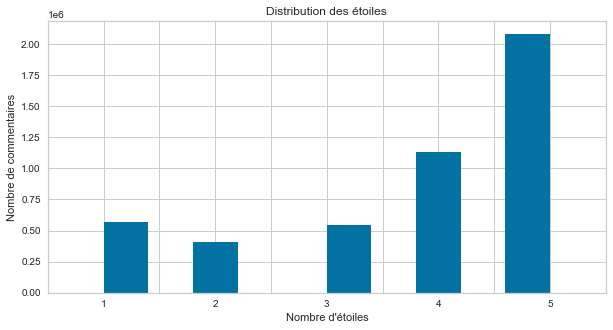

In [64]:
plt.figure(figsize=(10, 5))
restaurant_reviews.stars.hist()
plt.xlabel("Nombre d'étoiles")
ticks, labels = plt.xticks()
labels = ['', '1', '', '2', '', '3', '', '4', '', '5', '']
plt.xticks(ticks, labels)
plt.ylabel("Nombre de commentaires")
plt.title("Distribution des étoiles")
plt.show()

### Récupération des commentaires négatifs : 1 et 2 étoiles

In [65]:
rr1 = restaurant_reviews[restaurant_reviews["stars"] == 1]
rr2 = restaurant_reviews[restaurant_reviews["stars"] == 2]

In [66]:
print(f"Taille des reviews à 1 étoile : {np.round(getsizeof(rr1)/(1024.0**3), 2)} GB")
print(f"Taille des reviews à 2 étoiles : {np.round(getsizeof(rr2)/(1024.0**3), 2)} GB")

Taille des reviews à 1 étoile : 0.65 GB
Taille des reviews à 2 étoiles : 0.55 GB


### Sauvegarde des datasets utiles à l'étude

In [67]:
rr1.to_csv('data/restaurant_reviews_1.csv', index=False)
rr2.to_csv('data/restaurant_reviews_2.csv', index=False)
restaurants.to_csv('data/restaurants.csv', index=False)

In [16]:
#rr1 = pd.read_csv('data/restaurant_reviews_1.csv')
#rr2 = pd.read_csv('data/restaurant_reviews_2.csv')
restaurants = pd.read_csv('data/restaurants.csv')

<div class="alert alert-block alert-info">

Nous travaillerons dans un premier temps uniquement avec les commentaires à 1 étoile, en nous reservant la possibilité d'inclure les commentaires à 2 étoiles si besoin.
    
</div>

*[(Retour sommaire)](#ch0)*

# <div id="ch2" style="color:blue">2. Analyse des commentaires négatifs</div>

## <div id="ch2_1" style="color:orange">2.1 Nettoyage du texte</div>

### Vérification des données statistiques de base

In [69]:
rr1.describe(include='all')

C:\Users\aledo\AppData\Local\Temp\ipykernel_18920\4262370624.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  rr1.describe(include='all')


review_id                 user_id  \
count                   567185                  567185   
unique                  567185                  392501   
top     JrIxlS1TzJ-iCu79ul40cQ  EP8o8JnQSI0WEkeodwA8lA   
freq                         1                      98   
first                      NaN                     NaN   
last                       NaN                     NaN   
mean                       NaN                     NaN   
std                        NaN                     NaN   
min                        NaN                     NaN   
25%                        NaN                     NaN   
50%                        NaN                     NaN   
75%                        NaN                     NaN   
max                        NaN                     NaN   

                   business_id     stars         useful          funny  \
count                   567185  567185.0  567185.000000  567185.000000   
unique                   46064       NaN            NaN            NaN   
top     IkY2ticzHEn4QFn8hQLSWg       NaN            NaN            NaN   
freq                      1001       NaN            NaN            NaN   
first                      NaN       NaN            NaN            NaN   
last                       NaN       NaN            NaN            NaN   
mean                       NaN       1.0       1.101889       0.416885   
std                        NaN       0.0       2.589998       1.733867   
min                        NaN       1.0       0.000000       0.000000   
25%                        NaN       1.0       0.000000       0.000000   
50%                        NaN       1.0       0.000000       0.000000   
75%                        NaN       1.0       1.000000       0.000000   
max                        NaN       1.0     420.000000     792.000000   

                 cool                                               text  \
count   567185.000000                                             567185   
unique            NaN                                             565871   
top               NaN  At the height of the Omicron surge, Wendy's DO...   
freq              NaN                                                 10   
first             NaN                                                NaN   
last              NaN                                                NaN   
mean         0.149993                                                NaN   
std          0.804251                                                NaN   
min          0.000000                                                NaN   
25%          0.000000                                                NaN   
50%          0.000000                                                NaN   
75%          0.000000                                                NaN   
max        121.000000                                                NaN   

                       date  
count                567185  
unique               566340  
top     2014-05-10 10:13:24  
freq                      3  
first   2005-03-25 21:54:30  
last    2022-01-19 19:22:44  
mean                    NaN  
std                     NaN  
min                     NaN  
25%                     NaN  
50%                     NaN  
75%                     NaN  
max                     NaN

In [70]:
print(f"{int(rr1.iloc[0, 3])} étoile")
print("---------")
print(f"Chaque utilisateur a rédigé en moyenne {np.round(rr1.shape[0] / len(rr1['user_id'].unique()), 1)} reviews")
print(f"Chaque établissement a reçu en moyenne {np.round(rr1.shape[0] / len(rr1['business_id'].unique()), 1)} reviews")
print()

1 étoile
---------
Chaque utilisateur a rédigé en moyenne 1.4 reviews
Chaque établissement a reçu en moyenne 12.3 reviews



### Sélection des commentaires jugés les plus utiles et détection de la langue

In [71]:
rr1_useful = rr1.sort_values(by="useful", ascending=False).iloc[:10000, :]

In [72]:
rr1_useful['language'] = rr1_useful['text'].apply(lambda x: langid.classify(x)[0])

In [73]:
print("Langues détectées :")
print("-----------------")
for l in rr1_useful['language'].unique():
    print(f"{l}\t :: {rr1_useful[rr1_useful['language'] == l].shape[0]} occurrences")

Langues détectées :
-----------------
en	 :: 10000 occurrences


<div class="alert alert-block alert-info">

Tous les commentaires ayant été rédigés en anglais, l'utilisation des outils de lemmatisation par défaut de NLTK est possible, ce qui facilitera l'extraction de features.
    
</div>

### Nettoyage du texte

In [74]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\aledo\anaconda3\envs\p6\lib\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\aledo\anaconda3\envs\p6\lib\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\aledo\anaconda3\envs\p6\lib\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [75]:
stopwords = nltk.corpus.stopwords.words('english')
lemmatizer = WordNetLemmatizer()

In [495]:
def normalize_text(s):
    s = re.sub('[^a-zA-Z]', ' ', s)
    s = s.lower()
    s = [contractions.fix(word) for word in s.split()]
    s = [lemmatizer.lemmatize(word) for word in s if not word in set(stopwords)]
    s = ' '.join([word for word in s if len(word) >= 3])
    return s

In [496]:
rr1_useful['normalized'] = rr1_useful['text'].apply(normalize_text)
rr1_useful.dropna(subset='normalized', axis=0)
rr1_useful.shape

(10000, 12)

<div class="alert alert-block alert-info">

La nouvelle colonne `normalized` contient les chaînes de texte de commentaire après application des opérations de nettoyage suivantes :
- Enlèvement des signes de ponctuation
- Passage de tout le texte en minuscules
- Enlèvement des "stopwords" de langue anglaise
- Expension des contraction (par exemple *wouldn't* => *would not*)
- Lemmatisation (ramener chaque mot à son radical : puriel -> singulier | verbe conjugué -> infinitif | etc.
    
</div>

*[(Retour sommaire)](#ch0)*

## <div id="ch2_2" style="color:orange">2.2 Fréquence des termes</div>

### Mots les plus fréquents : mots seuls

In [79]:
def get_most_frequent_words(ser, min_ngram, max_ngram):
    vectorizer = CountVectorizer(ngram_range=(min_ngram, max_ngram))
    X = vectorizer.fit_transform(ser)
    wd_matrix = pd.DataFrame(
        X.toarray(), columns=vectorizer.get_feature_names_out()).transpose().sum(axis=1).sort_values(ascending=False)
    return wd_matrix

In [497]:
rr1_ng1 = get_most_frequent_words(rr1_useful['normalized'], 1, 1)

In [498]:
rr1_uni = pd.DataFrame(columns = ['ngram', 'occurrences'])

In [499]:
rr1_uni['ngram'] = rr1_ng1.index
rr1_uni['occurrences'] = rr1_ng1.values

In [500]:
rr1_uni.head(100)

ngram  occurrences
0         food        12920
1        place         9257
2          one         8947
3         like         8118
4         time         8033
5        would         8027
6          get         7186
7   restaurant         6958
8         back         6945
9        table         6514
10       order         6444
11     service         6048
12        said         5860
13        even         5610
14        good         5535
15       never         5416
16      minute         5155
17       asked         5083
18        came         4994
19     ordered         4918
20        told         4552
21       could         4456
22      people         4418
23         got         4304
24    customer         4221
25       drink         4145
26        know         3951
27  experience         3806
28      review         3745
29       owner         3713
30     manager         3706
31        come         3689
32      really         3644
33         say         3526
34        make         3479
35        went         3433
36         bar         3409
37         way         3354
38      server         3327
39       first         3319
40        menu         3282
41      friend         3178
42         two         3157
43        take         3132
44       going         3061
45         bad         3004
46        want         2944
47        also         2943
48       thing         2876
49        well         2857
50     another         2818
51    waitress         2783
52        took         2745
53        give         2691
54    business         2686
55        meal         2678
56        made         2667
57         eat         2610
58       night         2609
59         day         2590
60        ever         2588
61        hour         2569
62        left         2557
63       still         2521
64       staff         2445
65        wait         2438
66        much         2354
67      wanted         2348
68       right         2330
69      around         2324
70         see         2307
71     chicken         2287
72       pizza         2238
73      better         2204
74       great         2180
75         new         2153
76       think         2136
77       check         2120
78       since         2098
79        star         2048
80         let         2045
81   something         2026
82        away         2005
83        last         1975
84        year         1971
85      dinner         1915
86         try         1890
87       money         1886
88     nothing         1877
89       salad         1871
90        tell         1844
91        long         1822
92      called         1796
93       price         1794
94       point         1786
95        sure         1783
96        look         1780
97        room         1769
98      cheese         1768
99        rude         1761

### Mots les plus fréquents : bigrammes

In [82]:
rr1_ng2 = get_most_frequent_words(rr1_useful['normalized'], 2, 2)

MemoryError: Unable to allocate 46.9 GiB for an array with shape (10000, 629815) and data type int64

<div class="alert alert-block alert-warning">
    
La mémoire ne pouvant stocker toutes les combinaisons de n-grams, nous créons une fonction qui découpe le dataset en morceaux et assemble les résultats à l'issue de la recherche.
    
</div>

In [118]:
def ngrams_by_chunks(ser, min_ngram, max_ngram):
    len_ser = len(ser)
    left_value = -2000
    right_value = 0
    chunks = []
    while right_value < len_ser:
        left_value += 2000
        right_value = min(right_value + 2000, len_ser)
        chunks.append(get_most_frequent_words(ser.iloc[left_value:right_value], min_ngram, max_ngram))
    res = pd.concat(chunks, axis=0).reset_index()
    res.columns = ['ngram', 'occurrences']
    res = res.groupby('ngram').sum().sort_values(by='occurrences', ascending=False).reset_index()
    return res

In [501]:
rr1_ng2 = ngrams_by_chunks(rr1_useful['normalized'], 2, 2)

In [502]:
rr1_ng2.head(100)

ngram  occurrences
0    customer service         1112
1           come back          775
2        minute later          706
3           came back          613
4          first time          565
5         even though          541
6         tasted like          538
7            one star          443
8         looked like          410
9         credit card          405
10         going back          364
11         last night          364
12         said would          358
13         never back          353
14          last time          351
15        drink order          344
16          look like          337
17  dining experience          335
18          food good          331
19          make sure          322
20     another minute          317
21       food service          315
22         would like          306
23          went back          299
24           let know          298
25        new orleans          295
26          feel like          294
27          long time          294
28         take order          294
29           year old          288
30         needle say          285
31        asked could          275
32        walked away          269
33      waited minute          269
34        took minute          268
35        coming back          267
36         told would          265
37          good food          264
38        would never          263
39   made reservation          255
40        much better          252
41       never return          250
42         could give          250
43         wait staff          249
44         happy hour          248
45             do not          247
46          felt like          246
47         every time          242
48     somewhere else          239
49        dining room          238
50        star review          232
51          food came          226
52         waste time          225
53       asked wanted          221
54           get food          221
55     behind counter          220
56         mac cheese          219
57          next time          218
58      speak manager          218
59           year ago          216
60         took order          213
61       several time          212
62    experience ever          212
63         taste like          212
64     bad experience          209
65          could get          208
66     saturday night          207
67        pretty good          206
68         never came          203
69          stay away          201
70         give place          200
71       quality food          199
72           next day          197
73        seemed like          196
74         came table          195
75          half hour          193
76       someone else          193
77         bad review          192
78        bad service          190
79           big deal          190
80         never ever          190
81          get drink          186
82        parking lot          185
83           got food          184
84       friday night          183
85        yelp review          183
86       write review          182
87         front desk          181
88         right away          179
89         one person          178
90         would take          176
91        second time          174
92        finally got          173
93            did not          173
94          zero star          173
95         minute get          173
96         star would          172
97         order food          172
98         good thing          172
99        pretty much          171

### Mots les plus fréquents : trigrammes

In [503]:
rr1_ng3 = ngrams_by_chunks(rr1_useful['normalized'], 3, 3)

In [504]:
rr1_ng3.head(100)

ngram  occurrences
0                    by the way          128
1               never come back          111
2           asked speak manager          111
3              never going back           90
4              long story short           81
5                give zero star           81
6         worst experience ever           80
7       worst dining experience           75
8              waste time money           71
9              take drink order           70
10        poor customer service           70
11              one star review           70
12             took drink order           68
13              never came back           67
14         waited waited waited           67
15       worst customer service           66
16                  do not know           62
17              took minute get           61
18             let start saying           61
19              wish could give           60
20              could give star           57
21              could give zero           56
22            wanted like place           56
23           worst service ever           55
24            hard earned money           54
25    horrible customer service           54
26       recommend place anyone           54
27    terrible customer service           54
28              bad taste mouth           51
29              give place star           49
30       dining experience ever           49
31            never coming back           47
32              zero star would           47
33           really wanted like           47
34        waited another minute           46
35            add insult injury           45
36            back minute later           45
37            excited try place           43
38              came back table           43
39       customer service skill           42
40             could give place           42
41              give star would           41
42              never step foot           41
43               came back said           40
44            seated right away           40
45        customer service ever           40
46           nothing write home           40
47             get act together           40
48        good customer service           39
49              first last time           38
50             make eye contact           37
51            food good service           36
52           food mediocre best           36
53             soon as possible           36
54                   as soon as           36
55               last time went           36
56        would never recommend           36
57            would think would           35
58              first time ever           35
59          took another minute           35
60             asked would like           35
61               made feel like           34
62            french onion soup           34
63               get money back           34
64           give negative star           34
65                give one star           34
66     service ever experienced           33
67                 new year eve           33
68              said would take           32
69          wait another minute           32
70            make matter worse           32
71  worst restaurant experience           32
72               left bad taste           32
73       really looking forward           32
74               ever come back           31
75             food bad service           31
76        would recommend place           31
77        customer always right           30
78              one would think           30
79          negative star would           30
80             needle say never           30
81             one worst dining           29
82             took forever get           29
83            five minute later           29
84             ten minute later           29
85              used love place           29
86              would come back           29
87             sweet potato fry           28
88             came b

### Mots les plus fréquents : quadrigrammes

In [505]:
rr1_ng4 = ngrams_by_chunks(rr1_useful['normalized'], 4, 4)

In [506]:
rr1_ng4.head(100)

ngram  occurrences
0                could give zero star           48
1               could give star would           38
2        worst dining experience ever           38
3            really wanted like place           36
4                 as soon as possible           36
5                give zero star would           33
6         worst customer service ever           33
7                left bad taste mouth           31
8         one worst dining experience           29
9              came back minute later           22
10           could give negative star           21
11   worst experience ever restaurant           19
12            avoid place like plague           18
13            spend hard earned money           18
14                  http www yelp com           18
15              could give place star           17
16       never recommend place anyone           17
17  customer service ever experienced           16
18   worst restaurant experience ever           16
19        would never recommend place           16
20                   www yelp com biz           15
21               said would take care           15
22               wish could give star           14
23     worst service ever experienced           14
24              wish could give place           14
25               bad food bad service           14
26               give place zero star           14
27                 soft she will crab           14
28              would never come back           13
29               would give zero star           13
30              give place star would           13
31           give negative star would           13
32              could give place zero           13
33               wish could give zero           13
34           really wanted love place           12
35             told would minute wait           12
36       would recommend place anyone           12
37              come take drink order           12
38                give place one star           12
39               give zero star could           12
40  worst customer service experience           12
41             food took forever come           11
42              never come back place           11
43              never step foot place           10
44              needle say going back           10
45              came take drink order           10
46             straw broke camel back           10
47          far worst experience ever            9
48          let preface review saying            9
49           waitress never came back            9
50          like second class citizen            9
51               took minute get food            9
52           asked speak manager told            9
53           never seen anything like            9
54              needle say never back            9
55              make long story short            9
56          one worst experience ever            9
57           give place negative star            9
58               never ever come back            8
59      made reservation week advance            8
60           wish could give negative            8
61              excited try new place            8
62              never came back check            8
63              never came back table            8
64            trying make eye contact            8
65             come back minute later            8
66                took long time come            8
67           really excited try place            8
68              got seated right away            8
69              took minute get drink            8
70           asked speak manager said            8
71          give place another chance            8
72   customer service experience ever            8
73             minute later came back            8
74          could give place negative            8
75    one worst restaurant experience            8
76       waited waited waited finally            7
77             thought would give try            7
78 

### Mots les plus fréquents : quintigrammes

In [507]:
rr1_ng5 = ngrams_by_chunks(rr1_useful['normalized'], 5, 5)

In [508]:
rr1_ng5.head(100)

ngram  occurrences
0                  could give zero star would           31
1                       http www yelp com biz           15
2     worst customer service ever experienced           15
3            one worst dining experience ever           14
4              could give negative star would           12
5                   wish could give zero star           11
6                 could give place star would           11
7                  could give place zero star            9
8                  would give zero star could            9
9               wish could give negative star            8
10             could give place negative star            8
11     worst customer service experience ever            8
12            really really wanted like place            7
13         would never recommend place anyone            7
14                 wish could give place star            6
15                 took drink order came back            6
16                 http www philly com philly            6
17                   nazi proud boy stay away            5
18                needle say never going back            5
19                   place neo nazi proud boy            5
20                 wish could give place zero            5
21            aware recruiting place neo nazi            5
22          treated like second class citizen            5
23            recruiting place neo nazi proud            5
24             give place negative star would            5
25       one worst restaurant experience ever            5
26                really left bad taste mouth            5
27                    neo nazi proud boy stay            5
28            glass water multiple time never            4
29                  proud boy stay away aware            4
30            away aware recruiting place neo            4
31                   hour wait time wait left            4
32             would give negative star could            4
33         worst dining experience ever never            4
34            asked glass water multiple time            4
35                fool shame fool twice shame            4
36                 medium rare came well done            4
37            experience left bad taste mouth            4
38                    wait time wait left mad            4
39                  http www flickr com photo            4
40         water multiple time never received            4
41                       buy one get one free            4
42            asked wanted anything else said            4
43               around like chicken head cut            4
44           stay away aware recruiting place            4
45             boy stay away aware recruiting            4
46        worst service ever experienced life            4
47                  drive order pie hour wait            4
48                     www yelp com biz photo            4
49      worst dining experience recent memory            4
50                    pie hour wait time wait            4
51                   trying pull fast one get            4
52                 http www youtube com watch            4
53                 give place zero star would            4
54                   order pie hour wait time            4
55               waiter come take drink order            4
56           really really really wanted like            4
57         say america ordering speak english            3
58       minute ordering food minute ordering            3
59           floor basement food storage area            3
60                  give place one star would            3
61  probably worst restaurant experience ever            3
62          atmosphere star food star service            3
63            visiting new orleans first time            3
64               never came back refill water            3
65               seated right away given menu            3
66       far worst experience ever restaurant            3
67              take drink o

<div class="alert alert-block alert-info">

On s'aperçoit de plusieurs phénomènes à mesure que l'on augmente la taille des n_grammes :
- **Le sens devient plus explicite**, car il devient possible d'observer le contexte de chaque mot plus en détail
- **La représentativité diminue**, car il devient plus rare de trouver plusieurs occurrences d'exactement les mêmes mots dans le même ordre à travers différents commentaires
- **Les vrais raisons d'insatisfaction disparaissent**, car des expressions de 3 mots ou plus que l'on peut retrouver tel quel dans plusieurs commentaires tendent à être des expressions toutes faites (`the last straw that breaks the camel back` par exemple) ou l'expression d'une frustration pour laquelle il existe peu de variations (comme `I wish I could give this place zero stars`, `never come back`, ou encore `worst dining experience`)
    
Ainsi, dans la suite de l'étude, **nous nous intéresserons uniquement aux mots seuls et aux bigrammes**
    
</div>

*[(Retour sommaire)](#ch0)*

## <div id="ch2_3" style="color:orange">2.3 LDA</div>

<div class="alert alert-block alert-info">

La méthode **LDA** (*Latent Dirichlet Allocation*) est une approche de modélisation de sujet, méthode de *Machine Learning* non supervisée visant un regrouper les mots d'un corpus dans un nombre K de sujets en fonction de distribution de probabilité sur les densités document-sujet et sujet-mot.
    
Nous nous intéresserons successivement aux mots seuls (**unigrammes**) et aux combinaisons de 2 mots (**bigrammes**).
    
</div>

In [418]:
# Source : https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0
def compute_coherence_values(corpus, dictionary, nb_topics, a, b, data):
    lda_mod = gensim.models.LdaMulticore(corpus=corpus, id2word=dictionary, num_topics=nb_topics, random_state=11, chunksize=100, passes=10,
                                           alpha=a, eta=b)
    coherence_model_lda = CoherenceModel(model=lda_mod, texts=data, dictionary=dictionary, coherence='c_v')
    return coherence_model_lda.get_coherence()

### LDA : Unigrammes

<div class="alert alert-block alert-info">

Nous réécrivons ici la fonction de tokenisation afin qu'elle revoi un tableau de mots au lieu d'une chaîne de caractères.
    
</div>

In [509]:
def tokenize_text(s):
    s = re.sub('[^a-zA-Z]', ' ', s)
    s = s.lower()
    s = [contractions.fix(word) for word in s.split()]
    s = [lemmatizer.lemmatize(word) for word in s if (not word in set(stopwords)) & (len(word) > 2)]
    return s

In [510]:
rr1_useful['tokenized'] = rr1_useful['text'].apply(tokenize_text)

### Construction du dictionnaire et du corpus

In [511]:
dictionary = corpora.Dictionary(rr1_useful['tokenized'])
dictionary.filter_extremes()
corpus = [dictionary.doc2bow(text) for text in rr1_useful['tokenized']]

### Détermination du score de cohérence pour un nombre de sujets $K \in [2; 30]$

In [512]:
nb_top = []
coher = []
for i in range(2, 31):
    cv = compute_coherence_values(corpus=corpus, dictionary=dictionary, nb_topics=i, a=0.01, b=0.1, data=rr1_useful['tokenized'])
    nb_top.append(i)
    coher.append(cv)

In [513]:
uni_coherence = pd.DataFrame({'nb_topics': nb_top, 'coherence_score': coher})

<AxesSubplot:xlabel='nb_topics', ylabel='coherence_score'>

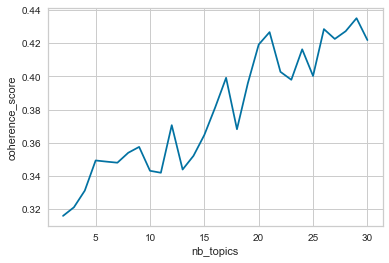

In [514]:
sns.lineplot(data=uni_coherence, x='nb_topics', y='coherence_score')

<div class="alert alert-block alert-info">

Sur cette courbe, à l'instar de la **méthode du coude**, nous recherchons le point d'inflexion de la courbe.
    
Ici, ce point semble être attein pour $K = 21$, mais on note également des modes intéressants pour :
- $K = 5$
- $K = 9$
- $K = 12$
- $K = 16$
    
Nous allons donc observer les mots les plus fréquents (donc les plus représentatifs) pour chacun de ces sujets afin de déterminer par nous-mêmes la cohérence des regroupements effectués par LDA.
    
Nous regrouperons les résultats dans une **représentation graphique en 2 dimensions** des résulats, puis nous répéterons l'opération pour les **bigrammes**.
    
</div>

In [517]:
nb_topics = 5
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=nb_topics, id2word=dictionary, passes=15)
topics = ldamodel.print_topics(num_words=5)
for topic in topics:
    print(topic)

(0, '0.021*"order" + 0.018*"pizza" + 0.013*"time" + 0.011*"burger" + 0.011*"get"')
(1, '0.019*"table" + 0.014*"minute" + 0.011*"order" + 0.010*"drink" + 0.010*"time"')
(2, '0.012*"like" + 0.010*"ordered" + 0.010*"chicken" + 0.009*"good" + 0.008*"restaurant"')
(3, '0.011*"owner" + 0.011*"customer" + 0.011*"would" + 0.009*"said" + 0.008*"never"')
(4, '0.010*"like" + 0.009*"one" + 0.007*"bar" + 0.006*"good" + 0.006*"get"')


In [518]:
nb_topics = 9
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=nb_topics, id2word=dictionary, passes=15)
topics = ldamodel.print_topics(num_words=5)
for topic in topics:
    print(topic)

(0, '0.027*"minute" + 0.020*"order" + 0.020*"table" + 0.015*"time" + 0.013*"wait"')
(1, '0.023*"bar" + 0.013*"drink" + 0.013*"like" + 0.010*"beer" + 0.010*"bartender"')
(2, '0.028*"room" + 0.013*"hotel" + 0.010*"would" + 0.009*"day" + 0.008*"night"')
(3, '0.016*"chicken" + 0.014*"like" + 0.012*"ordered" + 0.012*"sauce" + 0.011*"salad"')
(4, '0.016*"came" + 0.015*"table" + 0.014*"ordered" + 0.013*"waitress" + 0.013*"asked"')
(5, '0.011*"pizza" + 0.011*"like" + 0.009*"one" + 0.009*"time" + 0.006*"year"')
(6, '0.012*"sandwich" + 0.011*"like" + 0.011*"burger" + 0.010*"good" + 0.009*"coffee"')
(7, '0.026*"restaurant" + 0.014*"service" + 0.011*"experience" + 0.011*"table" + 0.011*"would"')
(8, '0.014*"said" + 0.014*"customer" + 0.012*"owner" + 0.011*"would" + 0.011*"told"')


In [519]:
nb_topics = 12
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=nb_topics, id2word=dictionary, passes=15)
topics = ldamodel.print_topics(num_words=5)
for topic in topics:
    print(topic)

(0, '0.022*"salad" + 0.018*"ordered" + 0.010*"meal" + 0.010*"came" + 0.009*"bread"')
(1, '0.017*"owner" + 0.015*"customer" + 0.013*"would" + 0.011*"business" + 0.010*"review"')
(2, '0.039*"steak" + 0.012*"like" + 0.011*"meat" + 0.011*"oyster" + 0.010*"vegan"')
(3, '0.068*"burger" + 0.021*"fry" + 0.017*"menu" + 0.011*"star" + 0.010*"indian"')
(4, '0.044*"order" + 0.019*"time" + 0.017*"back" + 0.016*"said" + 0.016*"minute"')
(5, '0.020*"pizza" + 0.013*"time" + 0.012*"restaurant" + 0.008*"one" + 0.007*"experience"')
(6, '0.016*"room" + 0.012*"like" + 0.010*"one" + 0.008*"get" + 0.008*"hotel"')
(7, '0.093*"bar" + 0.041*"bartender" + 0.035*"club" + 0.034*"night" + 0.034*"casino"')
(8, '0.017*"coffee" + 0.017*"price" + 0.014*"card" + 0.012*"tip" + 0.011*"charge"')
(9, '0.015*"like" + 0.011*"good" + 0.009*"chicken" + 0.008*"ordered" + 0.007*"sauce"')
(10, '0.062*"car" + 0.051*"parking" + 0.035*"dog" + 0.022*"gift" + 0.020*"valet"')
(11, '0.020*"table" + 0.012*"minute" + 0.011*"drink" + 0.010*

In [520]:
nb_topics = 16
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=nb_topics, id2word=dictionary, passes=15)
topics = ldamodel.print_topics(num_words=5)
for topic in topics:
    print(topic)

(0, '0.036*"bar" + 0.025*"drink" + 0.018*"friend" + 0.017*"bartender" + 0.016*"beer"')
(1, '0.013*"like" + 0.012*"one" + 0.006*"time" + 0.006*"good" + 0.006*"look"')
(2, '0.020*"order" + 0.018*"minute" + 0.017*"came" + 0.014*"waitress" + 0.014*"ordered"')
(3, '0.108*"steak" + 0.030*"bagel" + 0.028*"philly" + 0.026*"cheese" + 0.021*"cheesesteak"')
(4, '0.083*"coffee" + 0.050*"egg" + 0.048*"breakfast" + 0.030*"tea" + 0.021*"brunch"')
(5, '0.017*"said" + 0.016*"order" + 0.015*"told" + 0.013*"back" + 0.013*"time"')
(6, '0.017*"location" + 0.012*"time" + 0.012*"store" + 0.010*"get" + 0.010*"used"')
(7, '0.036*"card" + 0.033*"cake" + 0.032*"sushi" + 0.025*"charge" + 0.021*"tip"')
(8, '0.011*"sandwich" + 0.010*"one" + 0.010*"good" + 0.009*"price" + 0.009*"menu"')
(9, '0.110*"pizza" + 0.030*"taco" + 0.016*"mexican" + 0.012*"like" + 0.011*"salsa"')
(10, '0.014*"parking" + 0.014*"people" + 0.013*"get" + 0.012*"car" + 0.010*"lot"')
(11, '0.036*"room" + 0.020*"hotel" + 0.010*"day" + 0.009*"night" 

In [515]:
nb_topics = 21
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=nb_topics, id2word=dictionary, passes=15)
topics = ldamodel.print_topics(num_words=5)
for topic in topics:
    print(topic)

(20, '0.031*"bar" + 0.014*"bartender" + 0.013*"friend" + 0.012*"like" + 0.011*"drink"')
(6, '0.017*"said" + 0.014*"back" + 0.014*"told" + 0.014*"would" + 0.013*"manager"')
(7, '0.017*"steak" + 0.015*"ordered" + 0.013*"meal" + 0.011*"restaurant" + 0.011*"meat"')
(13, '0.022*"restaurant" + 0.016*"menu" + 0.015*"price" + 0.015*"reservation" + 0.013*"would"')
(16, '0.017*"like" + 0.009*"one" + 0.009*"people" + 0.008*"get" + 0.007*"want"')
(8, '0.084*"room" + 0.042*"hotel" + 0.022*"car" + 0.017*"stay" + 0.017*"casino"')
(19, '0.060*"order" + 0.060*"pizza" + 0.017*"ordered" + 0.017*"time" + 0.013*"delivery"')
(18, '0.031*"cheese" + 0.029*"salad" + 0.018*"bread" + 0.017*"sauce" + 0.013*"like"')
(14, '0.015*"rice" + 0.014*"sushi" + 0.014*"chicken" + 0.014*"fish" + 0.013*"roll"')
(9, '0.014*"chicken" + 0.013*"like" + 0.012*"sandwich" + 0.012*"fry" + 0.012*"order"')
(0, '0.075*"taco" + 0.040*"mexican" + 0.036*"chip" + 0.027*"salsa" + 0.027*"donut"')
(2, '0.015*"like" + 0.014*"better" + 0.013*"go

### Représentation graphique des unigrammes pour $K=21$

In [516]:
lda_display = pyLDAvis.gensim_models.prepare(ldamodel, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)

C:\Users\aledo\anaconda3\envs\p6\lib\site-packages\pyLDAvis\_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)


### LDA : Bigrammes

In [521]:
bigram = Phrases(rr1_useful['tokenized'], min_count=1, threshold=2, connector_words=ENGLISH_CONNECTOR_WORDS)
bigram_phraser = Phraser(bigram)
bigram_token = []
for sent in rr1_useful['tokenized']:
    bigram_token.append(bigram_phraser[sent])
bigram_dict = gensim.corpora.Dictionary(bigram_token)
bigram_dict.filter_extremes()
bigram_corpus = [bigram_dict.doc2bow(text) for text in bigram_token]

### Regroupements des bigrammes par valeur de $K$

In [526]:
nb_topics = 5
ldamodel = gensim.models.ldamodel.LdaModel(bigram_corpus, num_topics=nb_topics, id2word=bigram_dict, passes=15)
topics = ldamodel.print_topics(num_words=5)
for topic in topics:
    print(topic)

(0, '0.010*"get" + 0.008*"one" + 0.008*"said" + 0.007*"time" + 0.007*"told"')
(1, '0.009*"owner" + 0.008*"business" + 0.006*"customer" + 0.006*"place" + 0.006*"one"')
(2, '0.015*"food" + 0.012*"place" + 0.009*"like" + 0.008*"one" + 0.007*"good"')
(3, '0.015*"food" + 0.012*"restaurant" + 0.012*"table" + 0.011*"order" + 0.010*"one"')
(4, '0.025*"bar" + 0.021*"place" + 0.019*"drink" + 0.012*"beer" + 0.012*"coffee"')


In [529]:
nb_topics = 9
ldamodel = gensim.models.ldamodel.LdaModel(bigram_corpus, num_topics=nb_topics, id2word=bigram_dict, passes=15)
topics = ldamodel.print_topics(num_words=5)
for topic in topics:
    print(topic)

(0, '0.019*"food" + 0.012*"place" + 0.011*"like" + 0.007*"good" + 0.007*"one"')
(1, '0.009*"said" + 0.008*"one" + 0.008*"told" + 0.007*"would" + 0.007*"restaurant"')
(2, '0.070*"cake" + 0.020*"gluten_free" + 0.016*"bakery" + 0.011*"wedding" + 0.008*"croissant"')
(3, '0.017*"place" + 0.008*"one" + 0.007*"coffee" + 0.007*"get" + 0.007*"room"')
(4, '0.017*"bar" + 0.010*"place" + 0.009*"donut" + 0.007*"game" + 0.005*"smoke"')
(5, '0.025*"table" + 0.020*"food" + 0.014*"order" + 0.013*"drink" + 0.013*"minute"')
(6, '0.020*"pizza" + 0.018*"order" + 0.012*"food" + 0.010*"one" + 0.009*"ordered"')
(7, '0.027*"restaurant" + 0.007*"experience" + 0.007*"menu" + 0.007*"dish" + 0.007*"dinner"')
(8, '0.019*"burger" + 0.008*"customer" + 0.007*"place" + 0.006*"food" + 0.004*"get"')


In [530]:
nb_topics = 12
ldamodel = gensim.models.ldamodel.LdaModel(bigram_corpus, num_topics=nb_topics, id2word=bigram_dict, passes=15)
topics = ldamodel.print_topics(num_words=5)
for topic in topics:
    print(topic)

(0, '0.021*"order" + 0.015*"pizza" + 0.015*"said" + 0.012*"get" + 0.011*"minute"')
(1, '0.011*"restaurant" + 0.010*"food" + 0.008*"would" + 0.007*"like" + 0.007*"one"')
(2, '0.033*"room" + 0.018*"hotel" + 0.010*"night" + 0.009*"stay" + 0.009*"casino"')
(3, '0.034*"sandwich" + 0.008*"meat" + 0.005*"bread" + 0.005*"cupcake" + 0.004*"also"')
(4, '0.021*"food" + 0.011*"one" + 0.009*"place" + 0.008*"restaurant" + 0.007*"table"')
(5, '0.012*"vegan" + 0.010*"cheesesteak" + 0.007*"place" + 0.006*"bad" + 0.006*"geno"')
(6, '0.018*"table" + 0.016*"bar" + 0.014*"drink" + 0.011*"one" + 0.009*"place"')
(7, '0.012*"told" + 0.011*"manager" + 0.011*"would" + 0.010*"time" + 0.010*"order"')
(8, '0.019*"place" + 0.012*"like" + 0.010*"get" + 0.009*"coffee" + 0.009*"business"')
(9, '0.016*"place" + 0.011*"food" + 0.011*"like" + 0.010*"good" + 0.009*"sushi"')
(10, '0.025*"groupon" + 0.015*"coupon" + 0.015*"mask" + 0.014*"owner" + 0.011*"dog"')
(11, '0.078*"burger" + 0.038*"cake" + 0.014*"bagel" + 0.011*"ram

In [531]:
nb_topics = 16
ldamodel = gensim.models.ldamodel.LdaModel(bigram_corpus, num_topics=nb_topics, id2word=bigram_dict, passes=15)
topics = ldamodel.print_topics(num_words=5)
for topic in topics:
    print(topic)

(0, '0.018*"place" + 0.018*"food" + 0.012*"like" + 0.009*"burger" + 0.007*"really"')
(1, '0.017*"place" + 0.013*"bar" + 0.012*"one" + 0.012*"like" + 0.009*"drink"')
(2, '0.023*"table" + 0.018*"food" + 0.011*"order" + 0.010*"one" + 0.010*"restaurant"')
(3, '0.016*"one" + 0.014*"food" + 0.011*"place" + 0.011*"order" + 0.009*"came"')
(4, '0.015*"restaurant" + 0.014*"food" + 0.008*"like" + 0.008*"good" + 0.008*"one"')
(5, '0.027*"order" + 0.020*"pizza" + 0.017*"food" + 0.012*"time" + 0.011*"get"')
(6, '0.026*"mask" + 0.011*"bar_tender" + 0.009*"wearing_mask" + 0.009*"boise" + 0.006*"beard"')
(7, '0.017*"sushi" + 0.014*"place" + 0.011*"roll" + 0.010*"like" + 0.009*"price"')
(8, '0.009*"cheese" + 0.008*"grit" + 0.008*"crepe" + 0.007*"low_quality" + 0.006*"tomato"')
(9, '0.120*"cake" + 0.033*"bakery" + 0.020*"roach" + 0.011*"pastry" + 0.008*"baked_good"')
(10, '0.020*"dog" + 0.013*"truck" + 0.012*"http_www" + 0.012*"company" + 0.012*"food_poisoning"')
(11, '0.012*"service" + 0.009*"place" + 0

In [532]:
nb_topics = 21
ldamodel = gensim.models.ldamodel.LdaModel(bigram_corpus, num_topics=nb_topics, id2word=bigram_dict, passes=15)
topics = ldamodel.print_topics(num_words=5)
for topic in topics:
    print(topic)

(6, '0.023*"owner" + 0.012*"customer" + 0.011*"restaurant" + 0.010*"business" + 0.009*"people"')
(15, '0.052*"steak" + 0.018*"pasta" + 0.012*"meal" + 0.011*"bread" + 0.007*"well_done"')
(8, '0.046*"table" + 0.021*"restaurant" + 0.014*"minute" + 0.014*"food" + 0.014*"server"')
(16, '0.030*"groupon" + 0.013*"cupcake" + 0.012*"fianc" + 0.008*"told" + 0.008*"voucher"')
(14, '0.055*"order" + 0.017*"food" + 0.016*"time" + 0.015*"get" + 0.014*"place"')
(1, '0.049*"shrimp" + 0.037*"salad" + 0.028*"crab" + 0.018*"seafood" + 0.016*"ramen"')
(12, '0.013*"would" + 0.011*"manager" + 0.009*"said" + 0.008*"told" + 0.008*"back"')
(17, '0.033*"room" + 0.019*"hotel" + 0.012*"one" + 0.011*"night" + 0.010*"stay"')
(13, '0.051*"bar" + 0.043*"drink" + 0.021*"bartender" + 0.019*"beer" + 0.019*"friend"')
(10, '0.013*"place" + 0.009*"like" + 0.008*"restaurant" + 0.008*"one" + 0.006*"also"')
(5, '0.018*"food" + 0.012*"place" + 0.011*"one" + 0.009*"good" + 0.009*"like"')
(20, '0.026*"food" + 0.022*"chicken" + 0.

### Représentation graphique des bigrammes pour $K=21$

In [533]:
lda_display = pyLDAvis.gensim_models.prepare(ldamodel, bigram_corpus, bigram_dict, sort_topics=False)
pyLDAvis.display(lda_display)

C:\Users\aledo\anaconda3\envs\p6\lib\site-packages\pyLDAvis\_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)


<div class="alert alert-block alert-info">

Avant de tirer une conclusion sur la répartition des sujets, nous allons comparer les résultats de la LDA avec une recherche de sujets par NMF.
    
</div>

*[(Retour sommaire)](#ch0)*

## <div id="ch2_4" style="color:orange">2.4 TF-IDF & NMF</div>

<div class="alert alert-block alert-info">

**NMF** (*Non-negative Matrix Factorization*) est une technique de modélisation de sujets qui prend en entrée une matrice de fréquence des termes dans un ensemble de documents telle que celle fournie par **TF-IDF** (*Term Frequency - Inverse Document Frequency*) par exemple, et renvoi une liste de sujets comme autant d'ensembles pondérés de co-occurrences de mots.
    
</div>

<img src="img/nmf.png" style="height: 250px">

<div class="alert alert-block alert-info">

Nous allons utiliser cette technique pour représenter 21 sujets (afin de comparaison avec nos résultats LDA), d'abord sur les **unigrammes**, puis sur les **bigrammes**.
    
</div>

In [541]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic {}:".format(topic_idx))
        print(" | ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [534]:
nb_topics = 21

In [308]:
nb_top_words = 10

### TF-IDF & NMF : Unigrammes

In [301]:
tf1_uni = TfidfVectorizer(tokenizer=tokenize_text, stop_words=stopwords, min_df=2, max_df=0.95, ngram_range=(1, 1))

In [302]:
tf1_val = tf1_uni.fit_transform(rr1_useful['normalized'])
feat_uni = tf1_uni.get_feature_names_out()

In [535]:
nmf_uni = NMF(n_components=nb_topics, random_state=11, l1_ratio=0.5, init='nndsvd')

In [536]:
nmf_uni.fit(tf1_val)

C:\Users\aledo\anaconda3\envs\p6\lib\site-packages\sklearn\decomposition\_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


NMF(init='nndsvd', l1_ratio=0.5, n_components=21, random_state=11)

### Termes les plus fréquents pour les unigrammes avec $K=21$

In [542]:
display_topics(nmf_uni, feat_uni, nb_top_words)

Topic 0:
said | manager | asked | told | back | never | came | would | went | could
Topic 1:
salad | ordered | sauce | steak | dish | shrimp | meal | soup | like | menu
Topic 2:
pizza | crust | slice | topping | cheese | delivery | pepperoni | pie | oven | sauce
Topic 3:
table | minute | waitress | wait | seated | waited | hostess | waiting | came | sat
Topic 4:
bar | drink | bartender | beer | friend | night | glass | bouncer | one | group
Topic 5:
order | minute | delivery | time | hour | phone | called | call | ordered | get
Topic 6:
food | good | cold | mexican | eat | quality | price | got | buffet | hour
Topic 7:
reservation | party | made | group | told | would | hostess | hour | dinner | groupon
Topic 8:
burger | fry | medium | bun | cheese | patty | shake | ordered | beer | onion
Topic 9:
cake | wedding | bakery | birthday | cupcake | day | crab | would | chocolate | icing
Topic 10:
coffee | breakfast | egg | cup | shop | toast | counter | morning | barista | starbucks
Topic 1

### TF-IDF & NMF : Bigrammes

In [311]:
tf1_bi = TfidfVectorizer(tokenizer=tokenize_text, stop_words=stopwords, min_df=2, max_df=0.95, ngram_range=(2, 2))

In [312]:
tf1_bi_val = tf1_bi.fit_transform(rr1_useful['normalized'])
feat_bi = tf1_bi.get_feature_names_out()

In [538]:
nmf_bi = NMF(n_components=nb_topics, random_state=11, l1_ratio=0.5, init='nndsvd')

In [539]:
nmf_bi.fit(tf1_bi_val)

C:\Users\aledo\anaconda3\envs\p6\lib\site-packages\sklearn\decomposition\_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


NMF(init='nndsvd', l1_ratio=0.5, n_components=21, random_state=11)

### Termes les plus fréquents pour les bigrammes avec $K=21$

In [543]:
display_topics(nmf_bi, feat_bi, nb_top_words)

Topic 0:
came back | drink order | another minute | waited minute | took minute | take order | waited waited | minute get | never came | dining experience
Topic 1:
customer service | poor customer | worst customer | terrible customer | horrible customer | service never | service skill | service ever | bad customer | good customer
Topic 2:
first time | last time | even though | last night | year old | look like | behind counter | looked like | food good | somewhere else
Topic 3:
could give | zero star | star would | give zero | give star | wish could | negative star | would give | give place | star could
Topic 4:
credit card | card company | card number | gift card | day later | card machine | gave credit | next day | card charge | left cash
Topic 5:
come back | never come | food cold | bed bug | ever come | back place | would come | dim sum | back say | told come
Topic 6:
happy hour | hour menu | hour special | hour price | said happy | sit bar | hour bar | come happy | behind bar | we

<div class="alert alert-block alert-info">
    
<b>LDA et NMF : conclusion sur la recherche de sujets d'insatisfaction</b><br><br>

Nous pouvons observer plusieurs choses :
- Les représentation sont complémentaires : chacune des 4 représentations ci-dessus (LDA-unigrammes, LDA-bigrammes, NMF-unigrammes, NMF-bigrammes) apporte un éclairage différent sur les données et aucune ne peut se prévaloir de couvrir l'intégralité des sujets disponibles avec la division que nous avons choisi (21 sujets), bien que les représentations LDA semblent capturer les sujets avec moins de redondance et plus de précision.<br><br>
- La segmentation en un nombre faible de sujets appauvrit considérablement l'analyse : la sémantique est mélangée et il est alors difficile voire impossible d'attribuer un titre à chaque sujet. Au contraire, à partir de 16 sujets (et mieux encore pour 21) on constate une bonne séparation sémantique et une meilleure capacité d'analyse.<br><br>
- Les sujets ne sont pas de même importance informationnelle : ont trouve en effet une répartition par type de cuisine (japonaise, mexicaine, burgers, pâtisseries, etc.) qui ne nous intéresse pas, à côté de réels sujets transverses d'insatisfaction qui ont beaucoup plus d'intérêt.<br><br>
- Les sujets transverses d'insatisfaction trouvés via notre analyse sont les suivants :
>- Rapport qualité/prix
>- Qualité (en particulier le goût et l'aspect)
>- Prix (notamment l'application des réductions)
>- Service client
>- Temps d'attente
>- Professionalisme (en particulier l'attitude des serveurs)
>- Management (chefs de salle et propriétaires)
>- Propreté
>- Infestation (cafards, rats, etc.)
>- Accessibilité (normes handicapés)
>- Lieu et expérience (décoration, ambiance, etc.)
>- Livraison
>- Racisme
    
</div>

*[(Retour sommaire)](#ch0)*

## <div id="ch2_5" style="color:orange">2.5 Word embedding</div>

<div class="alert alert-block alert-info">

Nous allons en supplément utiliser une technique de ***word embedding*** afin de découvrir les termes présentant la plus grande similarité avec les motifs d'insatisfaction que nous avons trouvé.
    
</div>

In [544]:
# Source : https://inside-machinelearning.com/preprocessing-nlp-tutoriel-pour-nettoyer-rapidement-un-texte/#Word2Vec_Pre-entraine_par_Google
def display_closestwords(model, word, nb_closest):
    close_words = model.wv.most_similar(word)[:nb_closest]
    print("Word most similar to : "+word)
    print([sim_word[0] for sim_word in close_words])

In [321]:
w2v = Word2Vec(sentences=rr1_useful['tokenized'])
w2v.train(rr1_useful['tokenized'], total_examples=len(rr1_useful['tokenized']), epochs=50)

(52607015, 57794700)

In [547]:
display_closestwords(w2v, 'wait', 10)

Word most similar to : wait
['waiting', 'waited', 'sit', 'took', 'ready', 'later', 'closing', 'take', 'seated', 'timed']


In [548]:
display_closestwords(w2v, 'poisoning', 10)

Word most similar to : poisoning
['diarrhea', 'symptom', 'sick', 'ache', 'stomach', 'coli', 'tainted', 'ill', 'shipment', 'salmonella']


In [549]:
display_closestwords(w2v, 'service', 10)

Word most similar to : service
['experience', 'attitude', 'food', 'treatment', 'inattentive', 'consistently', 'ambiance', 'overall', 'exceptionally', 'atmosphere']


In [550]:
display_closestwords(w2v, 'food', 10)

Word most similar to : food
['meal', 'sushi', 'everything', 'service', 'pizza', 'entree', 'drink', 'apps', 'dish', 'actually']


In [551]:
display_closestwords(w2v, 'drink', 10)

Word most similar to : drink
['beer', 'cocktail', 'water', 'refill', 'beverage', 'round', 'soda', 'bartender', 'mimosa', 'appetizer']


In [552]:
display_closestwords(w2v, 'restaurant', 10)

Word most similar to : restaurant
['place', 'establishment', 'eatery', 'location', 'joint', 'considering', 'resturant', 'dining', 'people', 'venue']


In [553]:
display_closestwords(w2v, 'taste', 10)

Word most similar to : taste
['flavor', 'tasted', 'aftertaste', 'texture', 'consistency', 'marinade', 'tasteless', 'bland', 'overpowering', 'flavorless']


In [554]:
display_closestwords(w2v, 'accessibility', 10)

Word most similar to : accessibility
['braille', 'ramp', 'handicapped', 'accessible', 'height', 'congested', 'leading', 'wooden', 'lighting', 'loo']


In [555]:
display_closestwords(w2v, 'dirty', 10)

Word most similar to : dirty
['sticky', 'grimy', 'wipe', 'clean', 'wiped', 'filthy', 'silverware', 'cloth', 'mop', 'dingy']


In [556]:
display_closestwords(w2v, 'racism', 10)

Word most similar to : racism
['prejudice', 'discrimination', 'discriminating', 'undertone', 'bigoted', 'negativity', 'condone', 'cruelty', 'irresponsible', 'wikipedia']


In [558]:
display_closestwords(w2v, 'waiter', 10)

Word most similar to : waiter
['waitress', 'server', 'hostess', 'table', 'bartender', 'manager', 'waitstaff', 'maitre', 'sever', 'host']


In [559]:
display_closestwords(w2v, 'waitress', 10)

Word most similar to : waitress
['waiter', 'server', 'bartender', 'lady', 'manager', 'table', 'hostess', 'girl', 'finally', 'waitstaff']


In [560]:
display_closestwords(w2v, 'bartender', 10)

Word most similar to : bartender
['server', 'waitress', 'drink', 'waiter', 'bar', 'female', 'guy', 'girl', 'tab', 'bouncer']


In [561]:
display_closestwords(w2v, 'price', 10)

Word most similar to : price
['pricing', 'priced', 'quality', 'cost', 'expectation', 'expensive', 'amount', 'dollar', 'portion', 'carte']


In [562]:
display_closestwords(w2v, 'quality', 10)

Word most similar to : quality
['average', 'priced', 'subpar', 'mediocre', 'turnover', 'price', 'substandard', 'execution', 'superb', 'inconsistent']


In [565]:
display_closestwords(w2v, 'review', 10)

Word most similar to : review
['rating', 'reviewer', 'yelpers', 'yelp', 'post', 'yelper', 'feedback', 'bash', 'experience', 'update']


In [566]:
display_closestwords(w2v, 'star', 10)

Word most similar to : star
['rating', 'negative', 'rate', 'scathing', 'zagat', 'stellar', 'coveted', 'bash', 'merit', 'chance']


In [567]:
display_closestwords(w2v, 'like', 10)

Word most similar to : like
['stupid', 'embarassed', 'strange', 'think', 'kind', 'blankly', 'badly', 'funny', 'crap', 'shit']


In [568]:
display_closestwords(w2v, 'order', 10)

Word most similar to : order
['minute', 'min', 'ordering', 'ordered', 'check', 'forever', 'told', 'payment', 'pick', 'ask']


In [569]:
display_closestwords(w2v, 'table', 10)

Word most similar to : table
['seat', 'booth', 'seated', 'sat', 'party', 'server', 'waitress', 'hostess', 'plate', 'waiter']


In [570]:
display_closestwords(w2v, 'bar', 10)

Word most similar to : bar
['upstairs', 'bartender', 'patio', 'table', 'downstairs', 'booth', 'lounge', 'bench', 'outside', 'watched']


In [571]:
display_closestwords(w2v, 'owner', 10)

Word most similar to : owner
['manager', 'manger', 'management', 'supervisor', 'employee', 'swearing', 'kevin', 'pamela', 'verbatim', 'behalf']


In [572]:
display_closestwords(w2v, 'minute', 10)

Word most similar to : minute
['min', 'hour', 'patiently', 'order', 'minuet', 'moment', 'ten', 'forever', 'finally', 'eternity']


In [576]:
display_closestwords(w2v, 'customer', 10)

Word most similar to : customer
['patron', 'costumer', 'employee', 'business', 'client', 'job', 'management', 'people', 'respect', 'profession']


In [577]:
display_closestwords(w2v, 'reservation', 10)

Word most similar to : reservation
['appointment', 'arrangement', 'party', 'booking', 'seated', 'reserved', 'advance', 'hostess', 'beforehand', 'opentable']


In [578]:
display_closestwords(w2v, 'experience', 10)

Word most similar to : experience
['service', 'visit', 'review', 'treatment', 'impression', 'gamlin', 'incident', 'evening', 'experienced', 'encounter']


<div class="alert alert-block alert-info">
    
<b>Word embedding</b><br><br>

En utilisant le word embedding sur les mots représentant le plus nos sujets, nous sommes en mesure d'en visualiser le contexte et d'apprécier encore mieux le sens que les auteurs des avis avaient en tête en les utilisant.
    
Ceci complète l'analyse précédente adroitement. En effet, si nous souhaitons par exemple savoir ce qui a le plus dérangé les clients s'étant plaints de l'accessibilté, nous avons ici des éléments de réponse :
- l'absence de braille
- l'absence de rampe d'accès
- l'insuffisance de lumière
- l'étroitesse des circulations
- le manque d'accompagnement
- le manque d'équipements pour personnes handicapées
- la difficulté d'accès aux sanitaires
- la configuration du lieu (en particulier la hauteur)
- etc.
    
</div>

*[(Retour sommaire)](#ch0)*

# <div id="ch3" style="color:blue">3. Classification des images</div>

## <div id="ch3_1" style="color:orange">3.1 Extraction</div>

### Récupération des identifiants et des labels des photos

In [140]:
restaurants = pd.read_csv('data/restaurants.csv')

In [141]:
restaurant_ids = restaurants['business_id'].to_list()

In [142]:
pho = pd.read_json('data/photos.json', lines=True)

In [20]:
print(f"Nombre de photos : {pho.shape[0]}")

Nombre de photos : 200100


In [143]:
photos = pho[pho['business_id'].isin(restaurant_ids)]

In [22]:
print(f"Nombre de photos de restaurants : {photos.shape[0]}")

Nombre de photos de restaurants : 170467


In [23]:
photos.head()

photo_id             business_id  \
0  zsvj7vloL4L5jhYyPIuVwg  Nk-SJhPlDBkAZvfsADtccA   
1  HCUdRJHHm_e0OCTlZetGLg  yVZtL5MmrpiivyCIrVkGgA   
2  vkr8T0scuJmGVvN2HJelEA  _ab50qdWOk0DdB6XOrBitw   
3  pve7D6NUrafHW3EAORubyw  SZU9c8V2GuREDN5KgyHFJw   
4  H52Er-uBg6rNrHcReWTD2w  Gzur0f0XMkrVxIwYJvOt2g   

                                             caption    label  
0  Nice rock artwork everywhere and craploads of ...   inside  
1                                                     outside  
2                                     oyster shooter    drink  
3                                      Shrimp scampi     food  
4                                                        food

### Extraction des 200 premières photos pour chacune des 5 catégories (1000 photos)

In [24]:
print("Catégories :")
print("----------")
photos_cat = photos['label'].unique()
for idx, c in enumerate(photos_cat):
    print(f"{idx + 1} : {c}")

Catégories :
----------
1 : inside
2 : outside
3 : drink
4 : food
5 : menu


In [306]:
inside = photos.loc[photos['label'] == 'inside', ['photo_id', 'label']].iloc[:200]
outside = photos.loc[photos['label'] == 'outside', ['photo_id', 'label']].iloc[:200]
drink = photos.loc[photos['label'] == 'drink', ['photo_id', 'label']].iloc[:200]
food = photos.loc[photos['label'] == 'food', ['photo_id', 'label']].iloc[:200]
menu = photos.loc[photos['label'] == 'menu', ['photo_id', 'label']].iloc[:200]

### Copie de chaque photo dans un dossier représentant sa catégorie

In [218]:
def copy_image_list(ref_array, dest_folder):
    for r in ref_array:
        src_path = f"C:/Users/aledo/p6/data/photos/{r}.jpg"
        dst_path = f"C:/Users/aledo/p6/img/{dest_folder}/{r}.jpg"
        shutil.copy(src_path, dst_path)

In [307]:
copy_image_list(inside['photo_id'], 'inside')
copy_image_list(outside['photo_id'], 'outside')
copy_image_list(drink['photo_id'], 'drink')
copy_image_list(food['photo_id'], 'food')
copy_image_list(menu['photo_id'], 'menu')

### *Preprocessing* des images

In [220]:
# Source : https://towardsdatascience.com/increase-your-face-recognition-models-accuracy-by-improving-face-contrast-a3e71bb6b9fb
def improve_contrast_image_using_clahe(bgr_image: np.array) -> np.array:
    hsv = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2HSV)
    hsv_planes = cv2.split(hsv)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    hsv2 = clahe.apply(hsv_planes[2])
    hsv = cv2.merge([hsv_planes[0], hsv_planes[1], hsv2])
    return cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)

In [308]:
def preprocess_images(ref_array, dest_folder):
    for r in ref_array:
        dst_path = f"C:/Users/aledo/p6/img/{dest_folder}/{r}.jpg"
        img = cv2.imread(dst_path)
        img = cv2.resize(img, (224, 224))
        img = improve_contrast_image_using_clahe(img)
        img = Image.fromarray(img)
        img.save(dst_path)

In [309]:
preprocess_images(inside['photo_id'], 'inside')
preprocess_images(outside['photo_id'], 'outside')
preprocess_images(drink['photo_id'], 'drink')
preprocess_images(food['photo_id'], 'food')
preprocess_images(menu['photo_id'], 'menu')

<div class="alert alert-block alert-info">

En guise de *preprocessing*, nous avons ici effectué les opérations suivantes :
- Redimensionnement des images au format d'entrée de VGG16 (224 x 244 x 3)
- Egalisation d'histogramme par la méthode CLAHE (*Contrast Limited Adaptive Histogram Equalization*)
- *Preprocessing* de Keras : conversion des couleur de RGB en BGR et centrage des valeurs en 0
    
</div>

### Création d'un batch d'images et récupération des labels

In [310]:
img_ds = image_dataset_from_directory('C:/Users/aledo/p6/img', image_size=(224, 224), shuffle=False)

Found 1000 files belonging to 5 classes.


In [315]:
img_data = img_ds.unbatch()
labels = list(img_data.map(lambda x, y: y))
pictures = list(img_data.map(lambda x, y: x))

In [327]:
labels = map(int, labels)
labels = list(labels)

In [317]:
pictures = map(np.array, pictures)
pictures = list(pictures)

In [313]:
np.shape(labels)

(1000,)

In [456]:
labels[598]

2

### Représentation des images après *preprocessing*

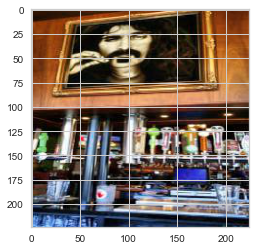

In [450]:
plt.imshow(cv2.imread("C:/Users/aledo/p6/img/inside/zsvj7vloL4L5jhYyPIuVwg.jpg"))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


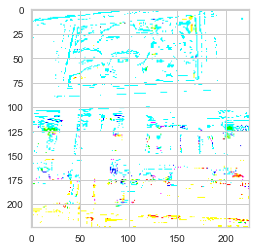

In [455]:
plt.imshow(pictures[598])

*[(Retour sommaire)](#ch0)*

## <div id="ch3_2" style="color:orange">3.2 SIFT</div>

<div class="alert alert-block alert-info">

**SIFT** (*Scale-Invariant Feature Transform*) est un algorithme de détection des similarités par extraction de caractéristiques (*feature extraction*) utilisé pour la reconnaissance d'images.
    
</div>

### Récupération des images

In [146]:
img_df = pd.concat([inside, outside, menu, food, drink])

In [148]:
img_df['path'] = img_df.apply(lambda x: f"C:/Users/aledo/p6/img/{x['label']}/{x['photo_id']}.jpg", axis=1)

In [153]:
label_encoder = LabelEncoder()
img_df['photo_class'] = label_encoder.fit_transform(img_df['label'])

In [155]:
img_df.head()

photo_id   label  \
0   zsvj7vloL4L5jhYyPIuVwg  inside   
7   bb7o8kXXXqc-8PWU6_wcuA  inside   
8   mcjlyGuLFJ0t4vDixycCSg  inside   
9   3ROd5PAQ_0OkmoKWVO06ag  inside   
11  yED5k8-aiPcgiUKoPRfJgg  inside   

                                                 path  photo_class  
0   C:/Users/aledo/p6/img/inside/zsvj7vloL4L5jhYyP...            2  
7   C:/Users/aledo/p6/img/inside/bb7o8kXXXqc-8PWU6...            2  
8   C:/Users/aledo/p6/img/inside/mcjlyGuLFJ0t4vDix...            2  
9   C:/Users/aledo/p6/img/inside/3ROd5PAQ_0OkmoKWV...            2  
11  C:/Users/aledo/p6/img/inside/yED5k8-aiPcgiUKoP...            2

In [158]:
img_df.groupby('photo_class').count().iloc[:, 0]

photo_class
0    200
1    200
2    200
3    200
4    200
Name: photo_id, dtype: int64

### Affichage de quelques images par catégorie

In [185]:
def list_fct(name) :
    list_image_name = [list_photos[i] for i in range(len(data)) if data["label_name"][i]==name]
    return list_image_name

inside
-------


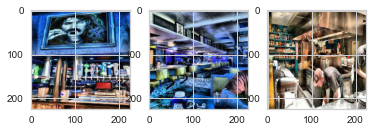

outside
-------


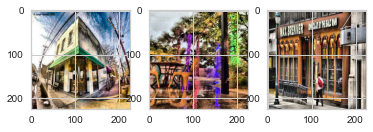

menu
-------


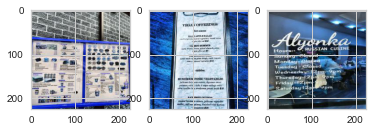

food
-------


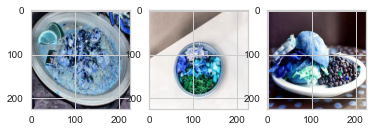

drink
-------


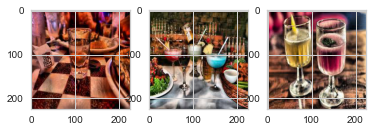

In [186]:
for name in ['inside', 'outside', 'menu', 'food', 'drink']:
    print(name)
    print("-------")
    sub_df = img_df[img_df['label'] == name].head(3).reset_index(drop=True)
    for i, row in sub_df.iterrows():
        plt.subplot(130 + 1 + i)
        image = imread(row['path'])
        plt.imshow(image)
    plt.show()

<div class="alert alert-block alert-info">

Les images que nous fournissons à SIFT ont subi le *preprocessing* **CLAHE** uniquement (donc sans le prétraitement de Keras).
    
</div>

### Création des descripteurs

In [187]:
sift_keypoints = []
temps1 = time.time()
sift = cv2.xfeatures2d.SIFT_create(500)

for i, row in img_df.reset_index(drop=True).iterrows():
    if i % 100 == 0:
        print(i)
    image = cv2.imread(row['path']) # convert in gray
    kp, des = sift.detectAndCompute(image, None)
    sift_keypoints.append(des)

sift_keypoints_by_img = np.asarray(sift_keypoints, dtype=object)
sift_keypoints_all = np.concatenate(sift_keypoints_by_img, axis=0)
print()
print(f"Nombre de descripteurs : {sift_keypoints_all.shape}")
print(f"temps de traitement SIFT descriptor : {np.round(time.time() - temps1, 2)} secondes")

0
100
200
300
400
500
600
700
800
900

Nombre de descripteurs : (456553, 128)
temps de traitement SIFT descriptor : 27.09 secondes


### Clusterisation des descripteurs

In [188]:
temps1 = time.time()
k = int(round(np.sqrt(len(sift_keypoints_all)), 0))
print(f"Nombre de clusters estimés : {k}")
print(f"Création de {k} clusters de descripteurs")
mini_batch = MiniBatchKMeans(n_clusters=k, init_size=3*k, random_state=11)
mini_batch.fit(sift_keypoints_all)
print(f"temps de traitement kmeans : {np.round(time.time() - temps1, 2)} secondes")

Nombre de clusters estimés : 676
Création de 676 clusters de descripteurs


C:\Users\aledo\anaconda3\envs\p6\lib\site-packages\sklearn\cluster\_kmeans.py:1836: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(


temps de traitement kmeans : 22.88 secondes


### Création des features des images

In [189]:
def build_histogram(kmeans, des, image_num):
    res = kmeans.predict(des)
    hist = np.zeros(len(kmeans.cluster_centers_))
    nb_des = len(des)
    if nb_des == 0:
        print(f"problème histogramme image : {image_num}")
    for i in res:
        hist[i] += 1.0 / nb_des
    return hist

In [190]:
temps1 = time.time()
hist_vectors = []
for i, image_desc in enumerate(sift_keypoints_by_img) :
    if i % 100 == 0 : print(i)  
    hist = build_histogram(mini_batch, image_desc, i) #calculates the histogram
    hist_vectors.append(hist) #histogram is the feature vector
im_features = np.asarray(hist_vectors)
print(f"temps de création histogrammes : {np.round(time.time() - temps1, 2)} secondes")

0
100
200
300
400
500
600
700
800
900
temps de création histogrammes : 12.51 secondes


### Réduction de dimensions par ACP

In [209]:
print(f"Dimensions dataset avant réduction PCA : {im_features.shape}")
scaler = StandardScaler()
im_scaled = scaler.fit_transform(im_features)
pca_sift = PCA(n_components=0.8)
feat_pca = pca_sift.fit_transform(im_scaled)
print(f"Dimensions dataset après réduction PCA : {feat_pca.shape}")

Dimensions dataset avant réduction PCA : (1000, 676)
Dimensions dataset après réduction PCA : (1000, 270)


In [492]:
km_sift_pca = KMeans(n_clusters=5, random_state=11)
km_sift_pca.fit(feat_pca)
print(f"Score ARI après ACP : {adjusted_rand_score(img_df['label'], km_sift_pca.labels_)}")

Score ARI après ACP : 0.1565252351611074


C:\Users\aledo\anaconda3\envs\p6\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


### Réduction de dimensions pas t-SNE

In [493]:
tsne = TSNE(n_components=2, perplexity=30, n_iter=2000, init='random', random_state=11)
X_tsne = tsne.fit_transform(feat_pca)
df_tsne = pd.DataFrame(X_tsne[:,0:2], columns=['tsne1', 'tsne2'])
df_tsne["class"] = img_df["label"]
print(f"Dimensions après t-SNE : {df_tsne.shape}")

C:\Users\aledo\anaconda3\envs\p6\lib\site-packages\sklearn\manifold\_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Dimensions après t-SNE : (1000, 3)


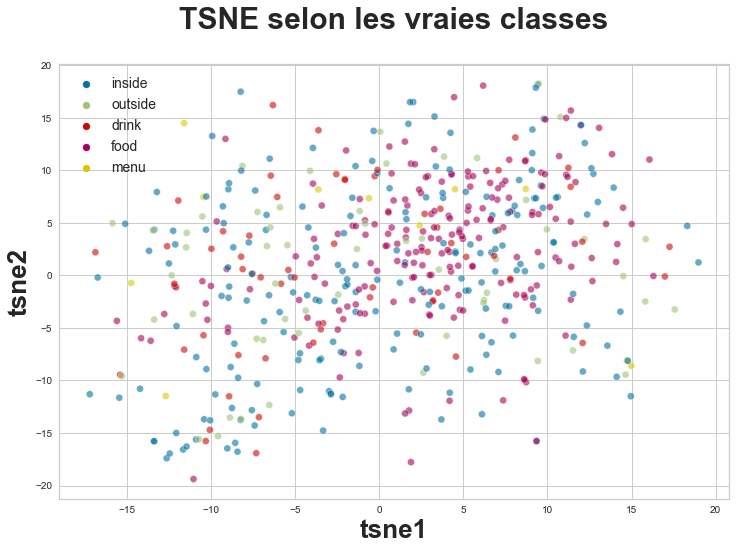

In [494]:
plt.figure(figsize=(12, 8))
sns.scatterplot(x="tsne1", y="tsne2", hue="class", data=df_tsne, legend="brief", s=50, alpha=0.6)
plt.title('TSNE selon les vraies classes', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 
plt.show()

In [495]:
km_sift = KMeans(n_clusters=5, random_state=11)
km_sift.fit(X_tsne)
df_tsne["cluster"] = km_sift.labels_

C:\Users\aledo\anaconda3\envs\p6\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


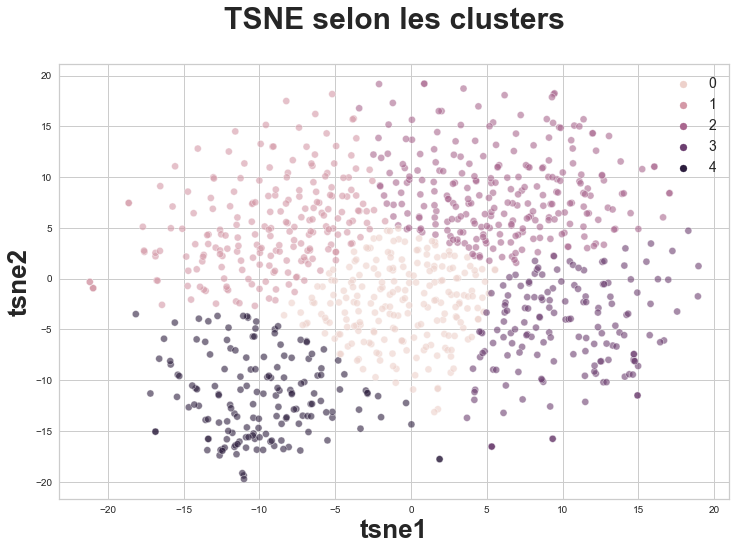

Score ARI après t-SNE : 0.1175142007713266


In [496]:
plt.figure(figsize=(12, 8))
sns.scatterplot(x="tsne1", y="tsne2", hue="cluster", s=50, alpha=0.6, data=df_tsne, legend="brief")
plt.title('TSNE selon les clusters', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14})
plt.show()
lab_sift = img_df["label"]
print(f"Score ARI après t-SNE : {adjusted_rand_score(lab_sift, km_sift.labels_)}")

<AxesSubplot:>

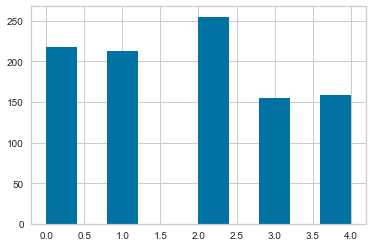

In [497]:
df_tsne['cluster'].hist()

In [498]:
confusion_matrix(img_df['photo_class'], km_sift.labels_)

array([[ 61,  69,  27,  28,  15],
       [ 32,  96,  42,  22,   8],
       [ 49,  20,  84,  39,   8],
       [ 13,   9,  21,  45, 112],
       [ 63,  19,  81,  21,  16]], dtype=int64)

In [500]:
print(classification_report(img_df['photo_class'], km_sift.labels_))

              precision    recall  f1-score   support

           0       0.28      0.30      0.29       200
           1       0.45      0.48      0.46       200
           2       0.33      0.42      0.37       200
           3       0.29      0.23      0.25       200
           4       0.10      0.08      0.09       200

    accuracy                           0.30      1000
   macro avg       0.29      0.30      0.29      1000
weighted avg       0.29      0.30      0.29      1000



<div class="alert alert-block alert-info">

<b>SIFT : conclusion</b><br><br>
    
Les résultats de SIFT ne sont pas très probants dans le cas qui nous intéresse :
- Le nombre de photo trouvée par catégorie est très variable : de 150 à 200 photos
- Le classement opéré sur les photos n'a rien à voir avec les étiquettes réelles, autrement dit les descripteurs trouvés ne sont pas ceux qui nous intéressent
    
Le second point est illustré par le score ARI très bas trouvé à l'issue du K-Means en sortie d'ACP (0.16), nombre qui diminue encore après application de t-SNE (0.12).
    
Nous allons comaprer ces résultats avec des méthodes faisant appel aux réseaux de neuronne convolutifs.
    
</div>

*[(Retour sommaire)](#ch0)*

## <div id="ch3_3" style="color:orange">3.3 Transfer Learning : VGG16</div>

### Récupération du modèle

In [460]:
vgg = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3), pooling='max')
vgg.trainable = False

In [461]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

<div class="alert alert-block alert-info">

On constate ici que notre modèle donne en sortie un vecteur de descripteurs de longueur 512.
    
C'est à travers les similitudes des vecteurs des images passées en entrées que nous parviendrons à les regrouper en différentes classes.
    
</div>

### Prédiction

In [463]:
pred = vgg.predict(img_ds)

32/32 [==============================] - 233s 7s/step


In [464]:
pred.shape

(1000, 512)

### Premier K-Means

In [465]:
X_scaled = StandardScaler().fit_transform(pred)

C:\Users\aledo\anaconda3\envs\p6\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\aledo\anaconda3\envs\p6\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\aledo\anaconda3\envs\p6\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\aledo\anaconda3\envs\p6\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known

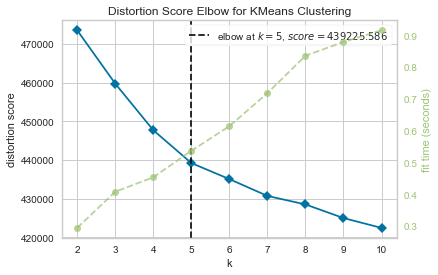

In [466]:
elbow_visu(X_scaled, 2, 10)

C:\Users\aledo\anaconda3\envs\p6\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\aledo\anaconda3\envs\p6\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\aledo\anaconda3\envs\p6\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\aledo\anaconda3\envs\p6\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known

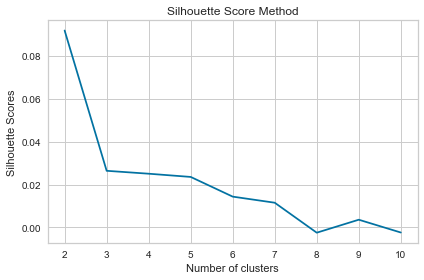

In [467]:
silhouette_graph(X_scaled, 2, 10)

In [468]:
km_pred = KMeans(n_clusters=5, random_state=11)
km_pred.fit(X_scaled)
print(f"Score ARI brut : {adjusted_rand_score(labels, km_pred.labels_)}")

C:\Users\aledo\anaconda3\envs\p6\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


Score ARI brut : 0.4598008242990195


### ACP et second K-Means

<div class="alert alert-block alert-info">

On recherche ici le pourcentage de variance minimal à conserver lors de l'ACP pour avoir un score ARI maximal en sortie du K-Means.
    
</div>

C:\Users\aledo\anaconda3\envs\p6\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\aledo\anaconda3\envs\p6\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\aledo\anaconda3\envs\p6\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\aledo\anaconda3\envs\p6\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known

<AxesSubplot:xlabel='n_components', ylabel='computed_ari'>

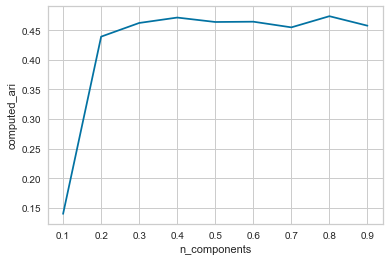

In [474]:
ari_pca = pd.DataFrame(columns=['n_components', 'computed_ari'])
for i in np.arange(0.1, 1, 0.1):
    pca_cnn = PCA(n_components=i)
    pca_cnn.fit(X_scaled)
    X_pca = pca_cnn.transform(X_scaled)
    km_cnn_pca = KMeans(n_clusters=5, random_state=11)
    km_cnn_pca.fit(X_pca)
    ari_pca.loc[len(ari_pca.index)] = [i, adjusted_rand_score(labels, km_cnn_pca.labels_)]
sns.lineplot(data=ari_pca, x='n_components', y='computed_ari')

<div class="alert alert-block alert-info">

On s'aperçoit que 40% de la variance suffisent à obtenir le même score qu'à 80% de variance, à savoir un score ARI de 0.47
    
</div>

In [475]:
pca_cnn = PCA(n_components=0.4)
pca_cnn.fit(X_scaled)
X_pca = pca_cnn.transform(X_scaled)
print(f"Dimensions avant ACP : {X_scaled.shape}")
print(f"Dimensions après ACP : {X_pca.shape}")

Dimensions avant ACP : (1000, 512)
Dimensions après ACP : (1000, 21)


In [476]:
km_cnn_pca = KMeans(n_clusters=5, random_state=11)
km_cnn_pca.fit(X_pca)
print(f"Score ARI après ACP : {adjusted_rand_score(labels, km_cnn_pca.labels_)}")

Score ARI après ACP : 0.471538173585247


C:\Users\aledo\anaconda3\envs\p6\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


### t-SNE et troisième K-Means

In [477]:
tsne = TSNE(n_components=2, perplexity=30, n_iter=2000, init='random', random_state=11)
X_tsne_cnn = tsne.fit_transform(X_pca)
df_tsne_cnn = pd.DataFrame(X_tsne_cnn[:, 0:2], columns=['tsne1', 'tsne2'])
df_tsne_cnn["class"] = img_df["label"]
print(f"Dimensions après t-SNE : {df_tsne_cnn.shape}")

C:\Users\aledo\anaconda3\envs\p6\lib\site-packages\sklearn\manifold\_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Dimensions après t-SNE : (1000, 3)


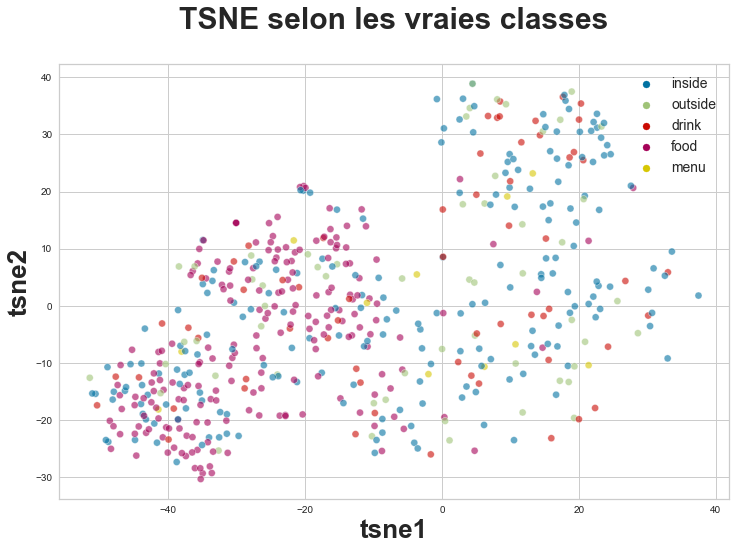

In [478]:
plt.figure(figsize=(12, 8))
sns.scatterplot(x="tsne1", y="tsne2", hue="class", data=df_tsne_cnn, legend="brief", s=50, alpha=0.6)
plt.title('TSNE selon les vraies classes', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 
plt.show()

In [479]:
km_cnn_tsne = KMeans(n_clusters=5, random_state=11)
km_cnn_tsne.fit(X_tsne_cnn)
df_tsne_cnn["cluster"] = km_cnn_tsne.labels_

C:\Users\aledo\anaconda3\envs\p6\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


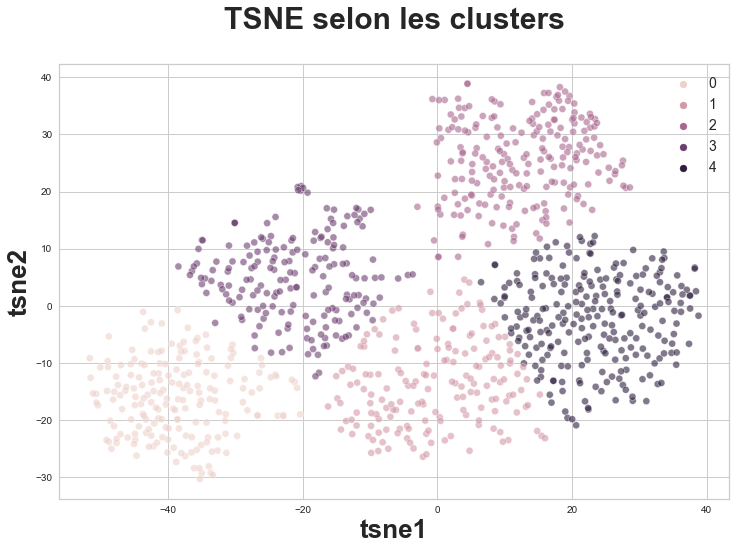

Score ARI après t-SNE : 0.533229525218234


In [480]:
plt.figure(figsize=(12, 8))
sns.scatterplot(x="tsne1", y="tsne2", hue="cluster", s=50, alpha=0.6, data=df_tsne_cnn, legend="brief")
plt.title('TSNE selon les clusters', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14})
plt.show()
lab_sift = img_df["label"]
print(f"Score ARI après t-SNE : {adjusted_rand_score(img_df['label'], km_cnn_tsne.labels_)}")

### Précision de la segmentation

<AxesSubplot:>

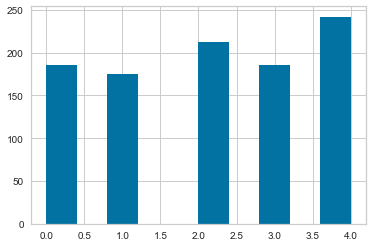

In [481]:
df_tsne_cnn['cluster'].hist()

In [482]:
confusion_matrix(img_df['photo_class'], km_cnn_tsne.labels_)

array([[  3,  29,  18,   1, 149],
       [  4,   9, 178,   4,   5],
       [  8,  31,   2, 156,   3],
       [  1,  97,  11,   6,  85],
       [170,   9,   3,  18,   0]], dtype=int64)

In [483]:
def conf_mat_transform(y_true, y_pred) :
    conf_mat = confusion_matrix(y_true,y_pred)
    #corresp = np.argmax(conf_mat, axis=0)
    corresp = [4, 3, 1, 2, 0]
    print ("Correspondance des clusters : ", corresp)
    #y_pred_transform = np.apply_along_axis(correspond_fct, 1, y_pred)
    labels = pd.Series(y_true, name="y_true").to_frame()
    labels['y_pred'] = y_pred
    labels['y_pred_transform'] = labels['y_pred'].apply(lambda x : corresp[x]) 
    return labels['y_pred_transform']

In [484]:
transformed_labels = conf_mat_transform(img_df['photo_class'], km_cnn_tsne.labels_)
print(confusion_matrix(img_df['photo_class'], transformed_labels))

Correspondance des clusters :  [4, 3, 1, 2, 0]
[[149  18   1  29   3]
 [  5 178   4   9   4]
 [  3   2 156  31   8]
 [ 85  11   6  97   1]
 [  0   3  18   9 170]]


<div class="alert alert-block alert-info">

La transformation opérée sur la matrice de confusion vise à trouver la correspondance entre nos vraies classes et celles trouvées par K-Means en sortie de VGG16 / ACP / t-SNE.
    
</div>

In [509]:
print("Correspondance classe-label sur le jeu initial :")
for lab in img_df['label'].unique():
    print(f"\t{lab} :: {int(img_df.loc[img_df['label'] == lab, 'photo_class'].head(1))}")

Correspondance classe-label sur le jeu initial :
	inside :: 2
	outside :: 4
	menu :: 3
	food :: 1
	drink :: 0


In [485]:
print(classification_report(img_df['photo_class'], transformed_labels))

              precision    recall  f1-score   support

           0       0.62      0.74      0.67       200
           1       0.84      0.89      0.86       200
           2       0.84      0.78      0.81       200
           3       0.55      0.48      0.52       200
           4       0.91      0.85      0.88       200

    accuracy                           0.75      1000
   macro avg       0.75      0.75      0.75      1000
weighted avg       0.75      0.75      0.75      1000



In [502]:
img_df['cnn_labels'] = transformed_labels
img_df.head()

photo_id   label  \
0   zsvj7vloL4L5jhYyPIuVwg  inside   
7   bb7o8kXXXqc-8PWU6_wcuA  inside   
8   mcjlyGuLFJ0t4vDixycCSg  inside   
9   3ROd5PAQ_0OkmoKWVO06ag  inside   
11  yED5k8-aiPcgiUKoPRfJgg  inside   

                                                 path  photo_class  cnn_labels  
0   C:/Users/aledo/p6/img/inside/zsvj7vloL4L5jhYyP...            2           3  
7   C:/Users/aledo/p6/img/inside/bb7o8kXXXqc-8PWU6...            2           2  
8   C:/Users/aledo/p6/img/inside/mcjlyGuLFJ0t4vDix...            2           2  
9   C:/Users/aledo/p6/img/inside/3ROd5PAQ_0OkmoKWV...            2           3  
11  C:/Users/aledo/p6/img/inside/yED5k8-aiPcgiUKoP...            2           2

### Erreurs de classification : `menu` classés en `drink` (85 photos en tout)

In [547]:
def error_mosaic(p_ids):
    p_ids = p_ids.head(16)
    plt.figure(figsize=(16, 16))
    for idx, pid in enumerate(p_ids.to_list()):
        plt.subplot(4, 4, idx + 1)
        plt.imshow(cv2.imread(img_df.loc[img_df['photo_id'] == pid, 'path'].to_list()[0]))
    plt.show()

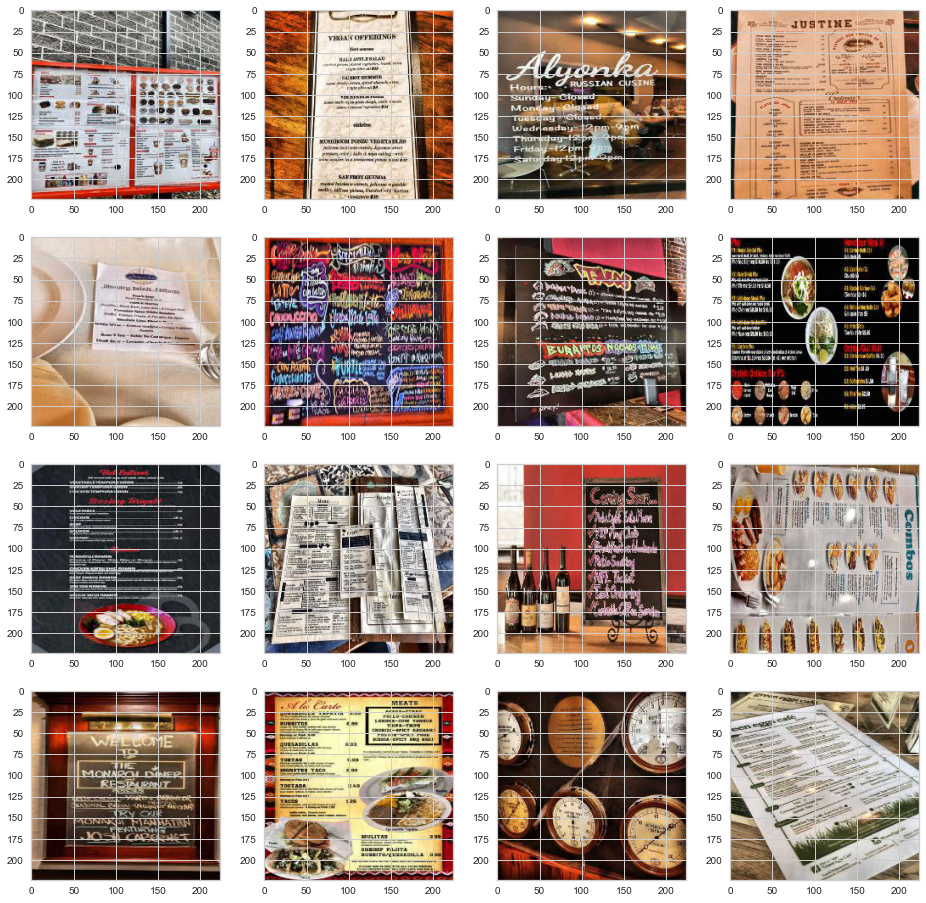

In [548]:
error_mosaic(img_df.loc[(img_df['cnn_labels'] == 0) & (img_df['photo_class'] == 3), 'photo_id'])

### Erreurs de classification : `inside` classés en `menu` (31 photos en tout)

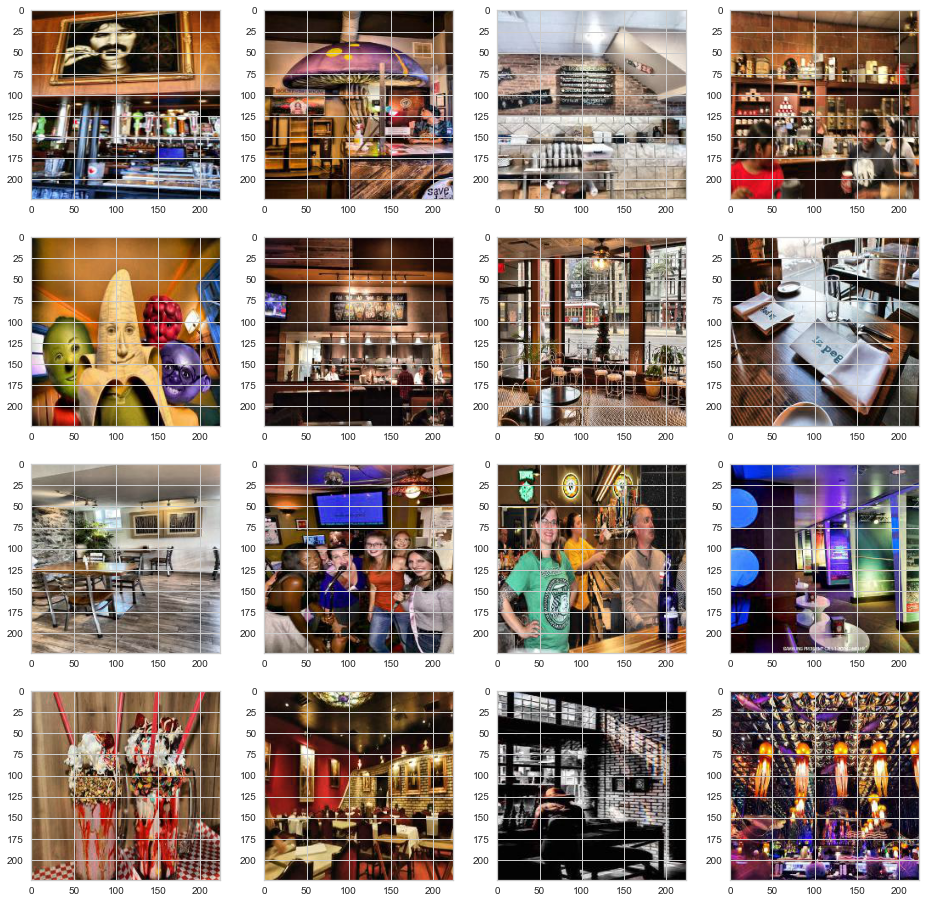

In [549]:
error_mosaic(img_df.loc[(img_df['cnn_labels'] == 3) & (img_df['photo_class'] == 2), 'photo_id'])

### Erreurs de classification : `drink` classés en `menu` (29 photos en tout)

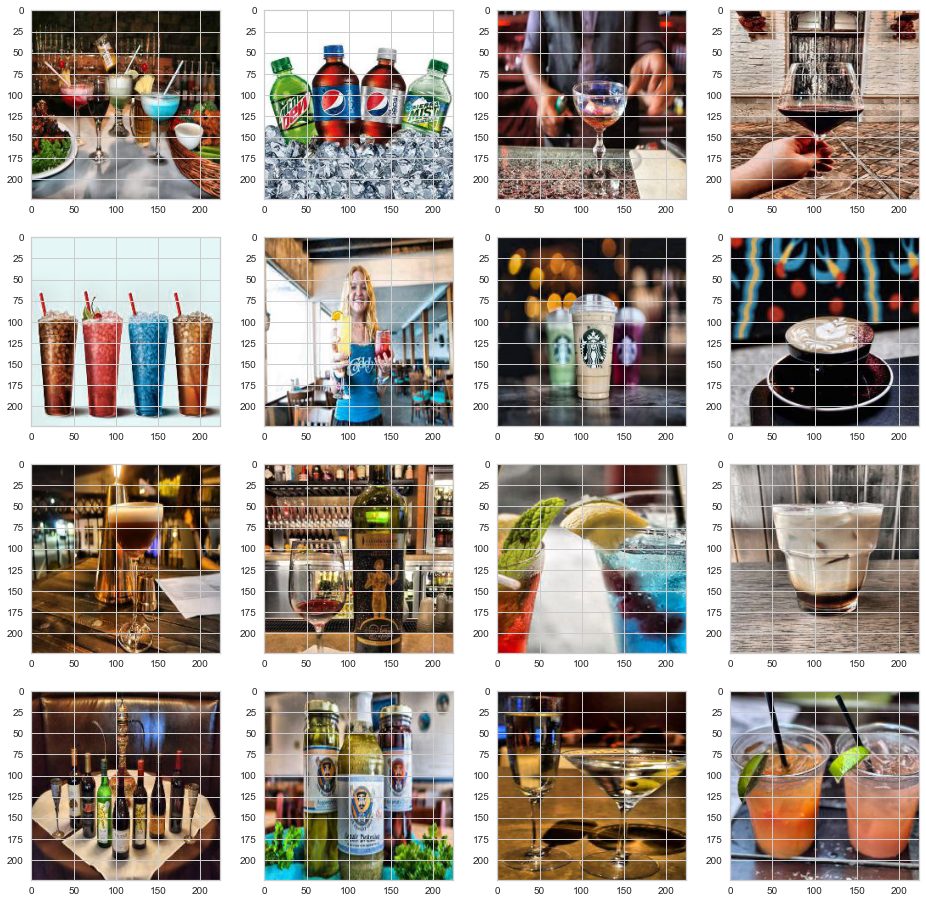

In [551]:
error_mosaic(img_df.loc[(img_df['cnn_labels'] == 3) & (img_df['photo_class'] == 0), 'photo_id'])

<div class="alert alert-block alert-info">

<b>VGG16 : conclusion</b><br><br>
    
On constate ici que les réseaux convolutifs donnent de bien meilleures performances sur notre jeu d'images (ARI 0.53, Accuracy 0.75) que la méthode SIFT (ARI 0.16, Accuracy 0.30).
    
    
Les photos les **mieux classées** appartiennent aux catégories `food` et `outside`.
    
    
La catégorie la **moins bien identifiée** par VGG16 est `menu` dont les images ont été classifiée en `drink` pour presque la moitié d'entre elles. En affichant les images sur lesquelles il y a eu erreur de classification, à part celles sur lesquelles apparaissent des bouteilles et des parties de verres, il est cependant difficile de comprendre quels descripteurs ont conduit à cette classification.
    
Ceci étant, les très bonnes performances montrées par la pipeline CNN -> ACP -> t-SNE -> K-Means indiquent qu'avec l'entraînement adéquat il sera possible d'étiqueter automatiquement les images avec une grande précision.
    
</div>

*[(Retour sommaire)](#ch0)*

## <div id="ch3_4" style="color:orange">3.4 Transfert Learning : ResNet50</div>

<div class="alert alert-block alert-info">

Afin de comparer nos résultats trouvés ci-dessus avec VGG16, nous allons effectuer les mêmes opérations en utilisant le réseau **ResNet50**, composé comme son nom l'indique de 50 couches.
    
</div>

### Récupération du modèle

In [553]:
resnet = ResNet50(weights="imagenet", include_top=False, input_shape=(224, 224, 3), pooling='max')
resnet.trainable = False

94765736/94765736 [==============================] - 12s 0us/step


In [554]:
resnet.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_7[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 56, 56, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 28, 28, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization) 

 conv4_block5_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block4_out[0][0]']       
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_blo

                                                                  'conv5_block1_3_bn[0][0]']      
                                                                                                  
 conv5_block1_out (Activation)  (None, 7, 7, 2048)   0           ['conv5_block1_add[0][0]']       
                                                                                                  
 conv5_block2_1_conv (Conv2D)   (None, 7, 7, 512)    1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block2_1_bn[0][0]']      
 n)       

### Prédiction

In [555]:
pred_resnet = resnet.predict(img_ds)

32/32 [==============================] - 92s 3s/step


In [556]:
pred_resnet.shape

(1000, 2048)

### Premier K-Means

In [557]:
X_scaled_resnet = StandardScaler().fit_transform(pred_resnet)

C:\Users\aledo\anaconda3\envs\p6\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\aledo\anaconda3\envs\p6\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\aledo\anaconda3\envs\p6\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\aledo\anaconda3\envs\p6\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known

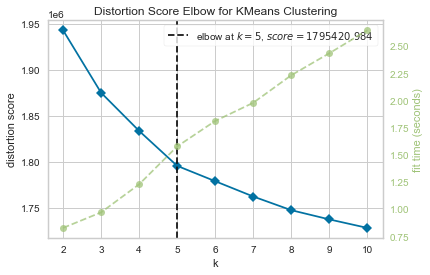

In [558]:
elbow_visu(X_scaled_resnet, 2, 10)

C:\Users\aledo\anaconda3\envs\p6\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\aledo\anaconda3\envs\p6\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\aledo\anaconda3\envs\p6\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\aledo\anaconda3\envs\p6\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known

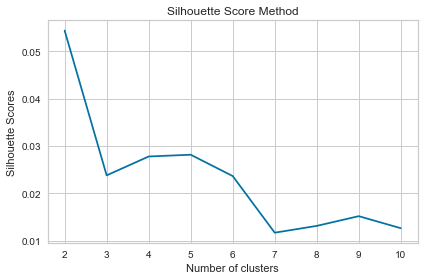

In [559]:
silhouette_graph(X_scaled_resnet, 2, 10)

In [560]:
km_pred_resnet = KMeans(n_clusters=5, random_state=11)
km_pred_resnet.fit(X_scaled_resnet)
print(f"Score ARI brut : {adjusted_rand_score(labels, km_pred_resnet.labels_)}")

C:\Users\aledo\anaconda3\envs\p6\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


Score ARI brut : 0.536333646979273


### ACP et second K-Means

C:\Users\aledo\anaconda3\envs\p6\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\aledo\anaconda3\envs\p6\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\aledo\anaconda3\envs\p6\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\aledo\anaconda3\envs\p6\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known

<AxesSubplot:xlabel='n_components', ylabel='computed_ari'>

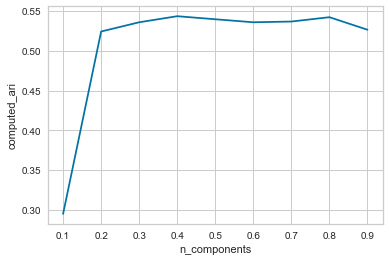

In [561]:
ari_pca_resnet = pd.DataFrame(columns=['n_components', 'computed_ari'])
for i in np.arange(0.1, 1, 0.1):
    pca_resnet = PCA(n_components=i)
    pca_resnet.fit(X_scaled_resnet)
    X_pca_resnet = pca_resnet.transform(X_scaled_resnet)
    km_resnet_pca = KMeans(n_clusters=5, random_state=11)
    km_resnet_pca.fit(X_pca_resnet)
    ari_pca_resnet.loc[len(ari_pca_resnet.index)] = [i, adjusted_rand_score(labels, km_resnet_pca.labels_)]
sns.lineplot(data=ari_pca_resnet, x='n_components', y='computed_ari')

In [562]:
pca_resnet = PCA(n_components=0.4)
pca_resnet.fit(X_scaled_resnet)
X_pca_resnet = pca_resnet.transform(X_scaled_resnet)
print(f"Dimensions avant ACP : {X_scaled_resnet.shape}")
print(f"Dimensions après ACP : {X_pca_resnet.shape}")

Dimensions avant ACP : (1000, 2048)
Dimensions après ACP : (1000, 28)


In [563]:
km_resnet_pca = KMeans(n_clusters=5, random_state=11)
km_resnet_pca.fit(X_pca_resnet)
print(f"Score ARI après ACP : {adjusted_rand_score(labels, km_resnet_pca.labels_)}")

Score ARI après ACP : 0.5434840625386322


C:\Users\aledo\anaconda3\envs\p6\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


### t-SNE et troisième K-Means

In [564]:
tsne_resnet = TSNE(n_components=2, perplexity=30, n_iter=2000, init='random', random_state=11)
X_tsne_resnet = tsne_resnet.fit_transform(X_pca_resnet)
df_tsne_resnet = pd.DataFrame(X_tsne_resnet[:, 0:2], columns=['tsne1', 'tsne2'])
df_tsne_resnet["class"] = img_df["label"]
print(f"Dimensions après t-SNE : {df_tsne_resnet.shape}")

C:\Users\aledo\anaconda3\envs\p6\lib\site-packages\sklearn\manifold\_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Dimensions après t-SNE : (1000, 3)


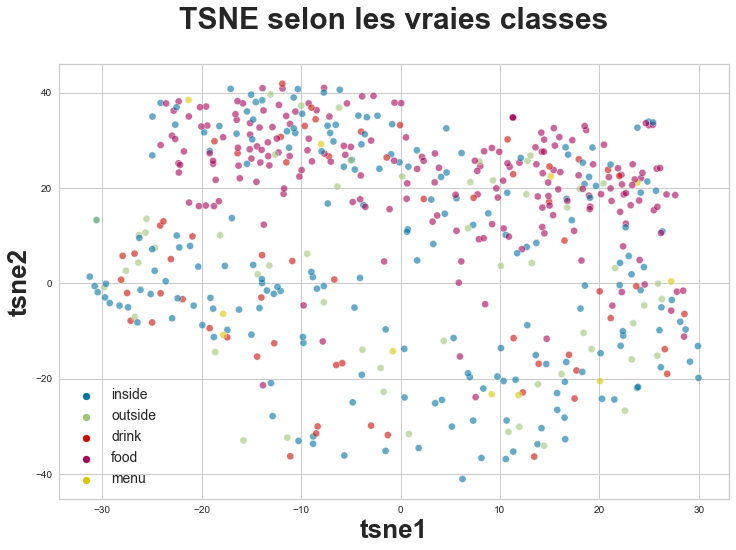

In [565]:
plt.figure(figsize=(12, 8))
sns.scatterplot(x="tsne1", y="tsne2", hue="class", data=df_tsne_resnet, legend="brief", s=50, alpha=0.6)
plt.title('TSNE selon les vraies classes', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 
plt.show()

In [566]:
km_resnet_tsne = KMeans(n_clusters=5, random_state=11)
km_resnet_tsne.fit(X_tsne_resnet)
df_tsne_resnet["cluster"] = km_resnet_tsne.labels_

C:\Users\aledo\anaconda3\envs\p6\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


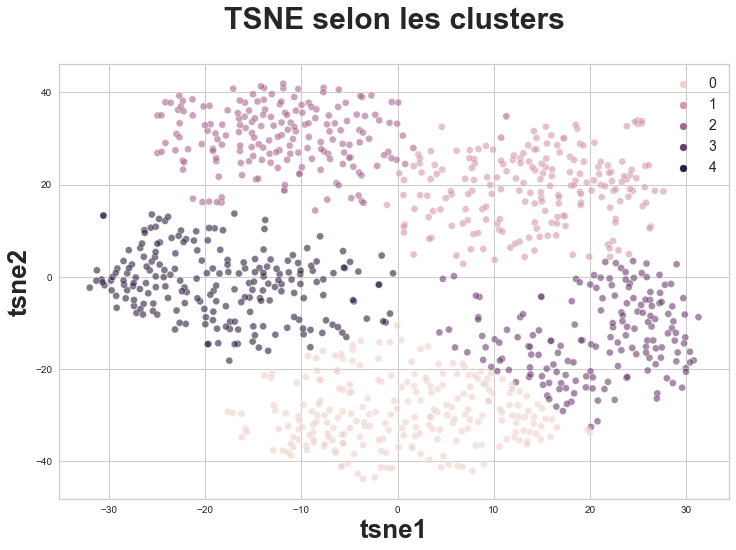

Score ARI après t-SNE : 0.589022343063851


In [567]:
plt.figure(figsize=(12, 8))
sns.scatterplot(x="tsne1", y="tsne2", hue="cluster", s=50, alpha=0.6, data=df_tsne_resnet, legend="brief")
plt.title('TSNE selon les clusters', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14})
plt.show()
print(f"Score ARI après t-SNE : {adjusted_rand_score(img_df['label'], km_resnet_tsne.labels_)}")

### Précision de la segmentation

<AxesSubplot:>

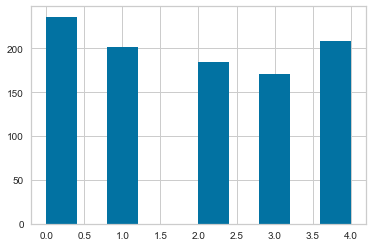

In [568]:
df_tsne_resnet['cluster'].hist()

In [569]:
confusion_matrix(img_df['photo_class'], km_resnet_tsne.labels_)

array([[146,   5,   0,  42,   7],
       [  3,   4,   3,   4, 186],
       [  2, 173,   3,  20,   2],
       [ 85,   7,   3,  95,  10],
       [  0,  12, 175,  10,   3]], dtype=int64)

In [570]:
def conf_mat_transform_resnet(y_true, y_pred) :
    conf_mat = confusion_matrix(y_true,y_pred)
    #corresp = np.argmax(conf_mat, axis=0)
    corresp = [0, 2, 4, 3, 1]
    print ("Correspondance des clusters : ", corresp)
    #y_pred_transform = np.apply_along_axis(correspond_fct, 1, y_pred)
    labels = pd.Series(y_true, name="y_true").to_frame()
    labels['y_pred'] = y_pred
    labels['y_pred_transform'] = labels['y_pred'].apply(lambda x : corresp[x]) 
    return labels['y_pred_transform']

In [572]:
transformed_labels = conf_mat_transform_resnet(img_df['photo_class'], km_resnet_tsne.labels_)
print(confusion_matrix(img_df['photo_class'], transformed_labels))

Correspondance des clusters :  [0, 2, 4, 3, 1]
[[146   7   5  42   0]
 [  3 186   4   4   3]
 [  2   2 173  20   3]
 [ 85  10   7  95   3]
 [  0   3  12  10 175]]


In [574]:
print(classification_report(img_df['photo_class'], transformed_labels))

              precision    recall  f1-score   support

           0       0.62      0.73      0.67       200
           1       0.89      0.93      0.91       200
           2       0.86      0.86      0.86       200
           3       0.56      0.47      0.51       200
           4       0.95      0.88      0.91       200

    accuracy                           0.78      1000
   macro avg       0.78      0.78      0.77      1000
weighted avg       0.78      0.78      0.77      1000



<div class="alert alert-block alert-info">

On obtient avec ResNet des performances comparables à VGG16, voire même légèrement supérieures :
    
<table>
    <thead>
        <tr>
            <th>Métrique</th>
            <th>VGG16</th>
            <th>ResNet50</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td>ARI brute</td>
            <td>0.46</td>
            <td>0.53</td>
        </tr>
        <tr>
            <td>ARI après ACP</td>
            <td>0.47</td>
            <td>0.54</td>
        </tr>
        <tr>
            <td>ARI après t-SNE</td>
            <td>0.53</td>
            <td>0.59</td>
        </tr>
        <tr>
            <td>Acuracy</td>
            <td>0.75</td>
            <td>0.78</td>
        </tr>
</table>
    
</div>

*[(Retour sommaire)](#ch0)*

# <div id="ch4" style="color:blue">4. Test de l'API</div>

<div class="alert alert-block alert-info">

Dans cette dernière partie, nous allons tenter de récupérer des informations fraîches de même nature que celles que nous avons utilisées lors de la phase de recherche des sujets d'insatisfaction, via l'API REST de Yelp.
    
A cette fin, nous comparerons 2 méthodes :
- **L'API classique de Yelp** : aujourd'hui la seule version stable disponible
- **L'API GraphQL** : API en version bêta très prometteuse qui semble correspondre plus à nos besoins, puisqu'elle permet de ne récupérer que les données qui nous intéressent
    
La clé d'API que nous avons utilisée ici est stockée en locale comme variable d'environnement sur le poste informatique ayant servi à l'étude.
    
</div>

In [4]:
API_KEY = os.environ.get('YELP_API_KEY')

## <div id="ch4_1" style="color:orange">4.1 API classique</div>

In [35]:
# Source : https://github.com/Yelp/yelp-fusion/blob/master/fusion/python/sample.py
API_HOST = 'https://api.yelp.com'
SEARCH_PATH = '/v3/businesses/search'
BUSINESS_PATH = '/v3/businesses/'  # Business ID will come after slash.
DEFAULT_TERM = 'restaurants'
DEFAULT_LOCATION = 'London, UK'
SEARCH_LIMIT = 50

def request(host, path, api_key, url_params=None):
    """Given your API_KEY, send a GET request to the API.
    Args:
        host (str): The domain host of the API.
        path (str): The path of the API after the domain.
        API_KEY (str): Your API Key.
        url_params (dict): An optional set of query parameters in the request.
    Returns:
        dict: The JSON response from the request.
    Raises:
        HTTPError: An error occurs from the HTTP request.
    """
    url_params = url_params or {}
    url = '{0}{1}'.format(host, quote(path.encode('utf8')))
    headers = {
        'Authorization': 'Bearer %s' % api_key,
    }
    response = requests.request('GET', url, headers=headers, params=url_params)
    return response.json()

def search(api_key, term, location, offset):
    """Query the Search API by a search term and location.
    Args:
        term (str): The search term passed to the API.
        location (str): The search location passed to the API.
    Returns:
        dict: The JSON response from the request.
    """
    url_params = {
        'term': term.replace(' ', '+'),
        'location': location.replace(' ', '+'),
        'limit': SEARCH_LIMIT,
        'offset': offset
    }
    return request(API_HOST, SEARCH_PATH, api_key, url_params=url_params)

def get_reviews(business_id):
    """Query the Business API by a business ID.
    Args:
        business_id (str): The ID of the business to query.
    Returns:
        dict: The JSON response from the request.
    """
    review_path = BUSINESS_PATH + business_id + '/reviews'
    return request(API_HOST, review_path, API_KEY)

def get_business_ids(term, location):
    """Queries the API by the input values from the user.
    Args:
        term (str): The search term to query.
        location (str): The location of the business to query.
    """
    biz_ids = []
    for offset in range(0, 151, 50):
        response = search(API_KEY, term, location, offset)
        businesses = response.get('businesses')
        for i in range(len(businesses)):
            biz_ids.append(businesses[i]['id'])
    return biz_ids

def get_new_reviews():
    try:
        b_ids = get_business_ids(DEFAULT_TERM, DEFAULT_LOCATION)
        reviews = []
        for b in b_ids:
            r = get_reviews(b).get('reviews')
            for i in range(len(r)):
                reviews.append({'business_id': b, 'stars': r[i]['rating'], 'text': r[i]['text']})
        return pd.DataFrame(reviews)
    except HTTPError as error:
        return f"Encountered HTTP error {error.code} on {error.url}:\n {error.read()}\nAbort program."

In [36]:
temps1 = time.time()
new_reviews = get_new_reviews()
temps2 = time.time() - temps1

In [37]:
nb_biz = len(new_reviews['business_id'].unique())
print(f"Récupération de {len(new_reviews)} nouveaux avis à propos de {nb_biz} restaurants.")
print(f"Requête effectuée en {np.round(temps2, 2)} secondes.")

Récupération de 592 nouveaux avis à propos de 200 restaurants.
Requête effectuée en 89.95 secondes.


In [38]:
new_reviews.head()

business_id  stars  \
0  Vaq49W0ubGjuIc4h5_qQ0w      5   
1  Vaq49W0ubGjuIc4h5_qQ0w      4   
2  Vaq49W0ubGjuIc4h5_qQ0w      4   
3  oK_SLmmAVQg3meguh7LrIA      5   
4  oK_SLmmAVQg3meguh7LrIA      5   

                                                text  
0  This place was absolutely delicious! It was a ...  
1  The food here is spot on. Portions were very w...  
2  This place is very popular for their beautiful...  
3  Fantastic chicken, beef, and mango lasses. Col...  
4  Just wow. Can't go wrong here. I'm Indian I wo...

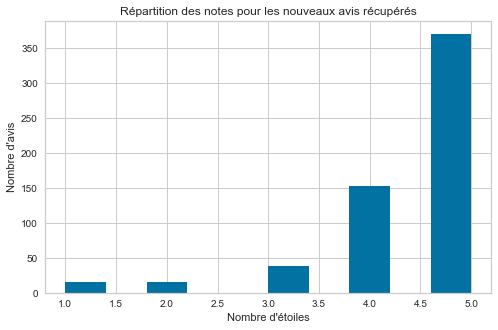

In [40]:
plt.figure(figsize=(8, 5))
new_reviews['stars'].hist()
plt.xlabel("Nombre d'étoiles")
plt.ylabel("Nombre d'avis")
plt.title("Répartition des notes pour les nouveaux avis récupérés")
plt.show()

In [41]:
new_reviews.to_csv('data/new_reviews.csv', index=False)

*[(Retour sommaire)](#ch0)*

## <div id="ch4_2" style="color:orange">4.2 API GraphQL</div>

In [46]:
import asyncio
from gql import Client, gql
from gql.transport.aiohttp import AIOHTTPTransport

In [129]:
API_HOST = 'https://api.yelp.com'
SEARCH_PATH = '/v3/graphql'
DEFAULT_TERM = 'restaurants'
DEFAULT_LOCATION = 'London, UK'
SEARCH_LIMIT = 50

async def gql_request(host, path, api_key, gql_query):
    url = '{0}{1}'.format(host, quote(path.encode('utf8')))
    headers = {
        'Authorization': 'Bearer %s' % api_key,
    }
    transport = AIOHTTPTransport(url=url, headers=headers)
    async with Client(
        transport=transport,
        fetch_schema_from_transport=True,
    ) as session:
        query = gql_query
        response = await session.execute(query)
        return response

async def gql_search(api_key, term, location, offset):
    query = gql(
        """
            {{
                search(term: "{0}", location: "{1}", limit: {2}, offset: {3}) {{
                    business {{
                        id
                        reviews {{
                            text
                            rating
                        }}
                    }}
                }}
            }}
        """.format(term, location, SEARCH_LIMIT, offset))
    return await gql_request(API_HOST, SEARCH_PATH, api_key, query)

def format_reviews(reviews):
    df_reviews = pd.DataFrame(columns=['business_id', 'stars', 'text'])
    for line in reviews:
        b_id = line['id']
        rev_arr = line['reviews']
        for rev_line in rev_arr:
            df_reviews.loc[len(df_reviews.index)] = [b_id, rev_line['rating'], rev_line['text']]
    return df_reviews

async def gql_new_reviews():
    try:
        reviews = []
        for offset in range(0, 151, 50):
            rev_offset = await gql_search(API_KEY, DEFAULT_TERM, DEFAULT_LOCATION, offset)
            reviews += rev_offset['search']['business']
        return format_reviews(reviews)
    except HTTPError as error:
        return f"Encountered HTTP error {error.code} on {error.url}:\n {error.read()}\nAbort program."

In [130]:
temps1 = time.time()
new_reviews = await gql_new_reviews()
temps2 = time.time() - temps1

In [131]:
nb_biz = len(new_reviews['business_id'].unique())
print(f"Récupération de {len(new_reviews)} nouveaux avis à propos de {nb_biz} restaurants.")
print(f"Requête effectuée en {np.round(temps2, 2)} secondes.")

Récupération de 593 nouveaux avis à propos de 200 restaurants.
Requête effectuée en 14.4 secondes.


In [132]:
new_reviews.head()

business_id  stars  \
0  Vaq49W0ubGjuIc4h5_qQ0w      5   
1  Vaq49W0ubGjuIc4h5_qQ0w      4   
2  Vaq49W0ubGjuIc4h5_qQ0w      4   
3  oK_SLmmAVQg3meguh7LrIA      5   
4  oK_SLmmAVQg3meguh7LrIA      5   

                                                text  
0  This place was absolutely delicious! It was a ...  
1  The food here is spot on. Portions were very w...  
2  This place is very popular for their beautiful...  
3  Fantastic chicken, beef, and mango lasses. Col...  
4  Just wow. Can't go wrong here. I'm Indian I wo...

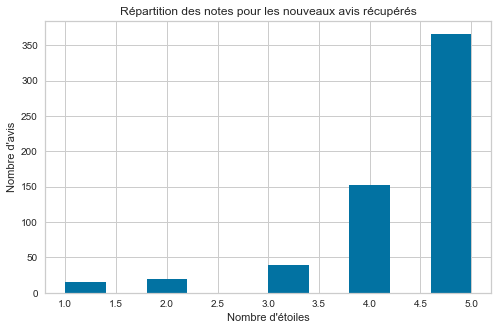

In [133]:
plt.figure(figsize=(8, 5))
new_reviews['stars'].hist()
plt.xlabel("Nombre d'étoiles")
plt.ylabel("Nombre d'avis")
plt.title("Répartition des notes pour les nouveaux avis récupérés")
plt.show()

<div class="alert alert-block alert-info">

<b>API Yelp : conclusion</b><br><br>
    
On constate ici que les résultats renvoyés sont exactement les mêmes en utilisant l'une ou l'autre des API de Yelp, cependant **l'API GraphQL est beaucoup plus performante**.
    
En effet, l'API GraphQL permet :
- Un temps de traitement 6 fois plus rapide de la requête que nous avons testée
- Le renvoi des seules informations demandées en une seule requête simple, donc des temps de développement beaucoup plus courts et une charge réseaux moindre
    
Concernant les résultats de l'appel API eux-mêmes :
- On s'aperçoit que seuls 3 avis par établissement sont disponibles (les 3 plus récents), ce qui implique soit d'augmenter le nombre d'établissements consultés, soit d'interroger à fréquence choisie l'API afin de recueillir les avis les plus fréquents à mesure qu'ils sont postés (avec recherche de doublons pour éliminer les éventuels avis déjà collecté)
- La réparition par nombre d'étoiles sur les avis collectés sont pauvres en avis négatifs, ce qui impliquera de collecter les avis de plus d'établissement et/ou d'étendre notre études aux avis ayant reçu 2 étoiles afin de disposer de suffisamment de données
    
</div>

*[(Retour sommaire)](#ch0)*

# <div id="ch5" style="color:blue">5. Conclusion</div>

<div class="alert alert-block alert-success">

**Notre étude de faisabilité est un succès**
    
<u><b>Détection des sujets d'insatisfaction</b></u>
    
Nous avons montré qu'avec les méthodes LDA et NMF, voire une combinaison des deux approches, il est possible de trouver les sujets d'insatisfaction principaux des usagers de Yelp. Afin d'être complète, notre pipeline pourra inclure les éléments suivants :
- Augmentation du volume du corpus de documents afin d'accroître la représentativité des sujets traités
- Détection automatique des sujets non-transverses, c'est-à-dire ceux liés uniquement à des types de cuisine
    
<u><b>Etiquetage automatique des photos</b></u>
    
Nous avons vu qu'avec un nombre très faible d'images en entrées et sans entraînement de classifieur spécifique, les réseaux convolutifs étaient déjà en mesure de retrouver les catégories désirées avec une précision intéressante en *transfer learning*. Afin d'être complète, notre approche de développement doit impliquer un *fine tuning* d'un modèle de réseau convolutif (VGG16 ou ResNet50 par exemple) sur une base d'image labellisée de volume conséquent.
    
<u><b>Test de l'API</b></u>
    
Nous avons constaté que l'API Yelp, en particulier la nouvelle interface GraphQL, permettait de récupérer avec une grande facilité de nouvelles données susceptibles d'alimenter nos modèles.
    
</div>

*[(Retour sommaire)](#ch0)*